## Machine Learning for EEG and SOT
### Tune the parameters using CV and test on a separate held out testing set 
### Rachneet Kaur

* Use EEG from the frontal channels as features and compare with EEG from F3/F4 channels as features
* Tune the model parameters using cross validation and then test on some held out set
* Put comparison table of ML algos and comparison of frontal and F3/F4 channels 
* Classify SOT in groups and model this as a binary classification problem 
* Find a rationale to classify SOT in 2 groups 
* Do a separate model for with perturbation trials and without perturbation trials and one model combining the both cases

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.decomposition import PCA as sklearnPCA
from scipy.stats import mode
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
#ML methods imports 
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from scipy import interp
from xgboost import XGBClassifier
import time 
import seaborn as sns
sns.set()

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [172]:
data_dir = "C:\\Users\\Rachneet Kaur\\Desktop\\UIUC\\Conference&Presenatations\\2019\\shou data\\"
file = "SOT_scores.csv"

In [173]:
file = pd.read_csv(data_dir + file)

In [174]:
file

,PID,SOT
0,101,85
1,102,75
2,105,80
3,106,86
4,109,81
5,111,70


In [175]:
#Making the dataframe with all features to work with 
#Data from participants HYA - 101, 102, 105, 106, 109, 111
#In total 38 trials 
index = ['101_trial1', '101_trial2', '101_trial3', '102_trial3', '102_trial4', '105_trial3', '105_trial4', '105_trial2', \
         '102_trial2', '106_trial1', '106_trial2', '106_trial3', '106_trial4', '109_trial1', '109_trial2', '109_trial3', \
        '111_trial1', '111_trial2', '111_trial3', '111_trial4']
label_list = [file.iloc[0,1]]*3 + [file.iloc[1,1]]*3 + [file.iloc[2,1]]*4 + [file.iloc[3,1]]*3 + [file.iloc[4,1]]*3 \
+ [file.iloc[5,1]]*4
labels = {'label':label_list}
data = pd.DataFrame(labels, index)

In [176]:
feat_dir = data_dir+ "HeightControlTrialWisePSD\\"
feat_101 = pd.read_csv(feat_dir+'HeightControl101_full_trial_features.csv')
feat_102 = pd.read_csv(feat_dir+'HeightControl102_full_trial_features.csv')
feat_105 = pd.read_csv(feat_dir+'HeightControl105_full_trial_features.csv')
feat_106 = pd.read_csv(feat_dir+'HeightControl106_full_trial_features.csv')
feat_109 = pd.read_csv(feat_dir+'HeightControl109_full_trial_features.csv')
feat_111 = pd.read_csv(feat_dir+'HeightControl111_full_trial_features.csv')
features_all = pd.concat((feat_101, feat_102, feat_105, feat_106, feat_109, feat_111))
features_all.index = data.index
complete_data = pd.concat((data, features_all), axis = 1)
complete_data.drop('Unnamed: 0', axis = 1, inplace = True)

In [177]:
#20 rows of data with 315 features, label as SOT scores and trial ID to identify trials with and withour perturbations
#Trials 1 and 4 are without perturbation whereas trials 2 and 3 are with perturbation 
print ('Full dataset shape = ', complete_data.shape)

Full dataset shape =  (20, 317)


In [178]:
#Assigning the binary label - 1 for SOT > 80 and 0 for SOT <=80
complete_data['binary_label'] = [int (i) for i in complete_data['label']>80]

In [179]:
complete_data.head()

,label,delta_Fp1,delta_Fz,delta_F3,delta_F7,delta_LHEye,delta_FC5,delta_FC1,delta_C3,delta_T7,...,gamma_C6,gamma_C2,gamma_FC4,gamma_FT8,gamma_F6,gamma_F2,gamma_AF4,gamma_RVEye,trialID,binary_label
101_trial1,85,0.634741,0.588945,0.576558,0.654219,0.777778,0.583753,0.536857,0.493918,0.259407,...,0.098046,0.073053,0.071584,0.098448,0.070853,0.063029,0.053079,0.050635,1,1
101_trial2,85,0.508068,0.535230,0.506431,0.457502,0.510955,0.426258,0.485100,0.441993,0.080221,...,0.073348,0.061185,0.061993,0.087194,0.085697,0.057438,0.052585,0.066761,2,1
101_trial3,85,0.536136,0.494493,0.460792,0.374468,0.384337,0.419879,0.421391,0.347715,0.222581,...,0.089240,0.065317,0.067988,0.105681,0.086637,0.061072,0.053796,0.037741,3,1
102_trial3,75,0.806052,0.628752,0.640024,0.673956,0.806532,0.532072,0.537800,0.449805,0.476718,...,0.088477,0.041924,0.063669,0.093085,0.099084,0.036543,0.026682,0.017967,3,0
102_trial4,75,0.774238,0.651649,0.651359,0.678428,0.706045,0.575936,0.532247,0.445760,0.368628,...,0.067143,0.038302,0.044621,0.109874,0.070624,0.037241,0.033572,0.020062,4,0


## Defining the training set for CV for parameter search and testing held out set

In [180]:
y = complete_data['binary_label']
drop_list = ['trialID', 'label' , 'binary_label']
X = complete_data.drop(drop_list, axis =1)

#Defining the training and the testing split with stratify = y means equal distribution of 0/1 labels 
#in both training and testing sets
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, stratify=y)


In [181]:
print ('Training and tetsing dataset shapes = ', train_X.shape, test_X.shape, train_y.shape, test_y.shape)

Training and tetsing dataset shapes =  (14, 315) (6, 315) (14,) (6,)


## Retrieving the same training and testing set each time

In [182]:
#Saving the train and test sets in .csv files 
#Retrieving the same training and testing set each time 
train_X.to_csv('train_X.csv')
train_y.to_csv('train_y.csv')
test_X.to_csv('test_X.csv')
test_y.to_csv('test_y.csv')

In [183]:
#Retrieving the same training and testing set each time 
train_X = pd.read_csv('train_X.csv', index_col = 0)
train_y = pd.read_csv('train_y.csv', header = None, index_col = 0)
test_X = pd. read_csv('test_X.csv', index_col = 0)
test_y = pd.read_csv('test_y.csv', header = None, index_col = 0)

## Modeling

In [184]:
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}

## Selecting a few frontal channels 

In [185]:
left_frontal_channels = ['AF7', 'AF3', 'F7', 'F5', 'F3', 'F1', 'FC5', 'FC3']
right_frontal_channels = ['AF4', 'RVEye', 'F2', 'F4', 'F6', 'F8', 'FC4', 'FC6']
frontal_channels = left_frontal_channels + right_frontal_channels

#Frontal channels and all 5 bands 
frontal = ['delta_'+chan for chan in frontal_channels] + ['theta_'+chan for chan in frontal_channels] + \
['alpha_'+chan for chan in frontal_channels] + ['beta_'+chan for chan in frontal_channels] + \
['gamma_'+chan for chan in frontal_channels]

In [186]:
train_frontal_x = train_X[frontal]
test_frontal_x = test_X[frontal]

In [187]:
train_frontal_x.head()

,delta_AF7,delta_AF3,delta_F7,delta_F5,delta_F3,delta_F1,delta_FC5,delta_FC3,delta_AF4,delta_RVEye,...,gamma_FC5,gamma_FC3,gamma_AF4,gamma_RVEye,gamma_F2,gamma_F4,gamma_F6,gamma_F8,gamma_FC4,gamma_FC6
109_trial2,0.780880,0.773337,0.723031,0.687526,0.686964,0.683263,0.644000,0.625810,0.813907,0.873780,...,0.112463,0.081410,0.026503,0.009439,0.034870,0.039522,0.042695,0.077297,0.068018,0.085592
105_trial2,0.716334,0.705805,0.631233,0.647436,0.648113,0.641428,0.626538,0.592301,0.695893,0.780680,...,0.055943,0.054721,0.042223,0.042043,0.132030,0.062189,0.177310,0.153884,0.076899,0.204005
106_trial2,0.775504,0.620813,0.610828,0.559130,0.534685,0.533372,0.478647,0.484317,0.608929,0.665285,...,0.202988,0.190861,0.120046,0.107215,0.155880,0.182249,0.220021,0.198149,0.193551,0.249291
102_trial3,0.695659,0.740285,0.673956,0.620268,0.640024,0.624857,0.532072,0.518236,0.720316,0.838557,...,0.129898,0.098173,0.026682,0.017967,0.036543,0.112648,0.099084,0.062487,0.063669,0.166536
109_trial1,0.798211,0.757507,0.740210,0.714825,0.715122,0.691425,0.711076,0.687793,0.720994,0.815516,...,0.053369,0.043921,0.044015,0.024424,0.043951,0.073354,0.122957,0.123117,0.099351,0.164566


## Linear SVM

In [188]:
#Linear SVM
depths = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]

#Cross validation for finding optimal parameters for the model
for depth in depths:
    model_svm = LinearSVC(C = depth)
    print ('\nDepth = ', depth)
    scores = cross_validate(model_svm, train_frontal_x, train_y, cv=5, scoring = scoring)
    print ('Accuracy', scores['test_accuracy'].mean(), scores['test_accuracy'].std())
    print ('Precision', scores['test_precision'].mean(), scores['test_precision'].std())
    print ('Recall', scores['test_recall'].mean(), scores['test_recall'].std())
    print ('F1 Score', scores['test_f1_score'].mean(), scores['test_f1_score'].std())
    #model accuracy for validation sets  
    #print (depth, 'Mean of 5 fold CV scores: ', np.mean(scores),' and Standard Deviation = ', np.std(scores))



Depth =  0.1
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Depth =  0.2
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Depth =  0.3
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Depth =  0.4
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Depth =  0.5
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Depth =  0.6
Accuracy 0.8666666666666666 0.16329931618554522
Precision 0.6 0.48989794855663565
Recall 0.6 0.48989794855663565
F1 Score

In [316]:
#The depth with maximum F1 score in the cross validation step is selected as the optimal depth
optimal_depth = 1.0
model_svm = LinearSVC(C = optimal_depth)
model_svm.fit(train_frontal_x, train_y)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [317]:
#Testing of the model on the held out test set for resporting the results 
pred_y = model_svm.predict(test_frontal_x)
#We will use micro average to report the results in paper
print('On the test set: ', classification_report(test_y, pred_y))


On the test set:                precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.75      1.00      0.86         3

   micro avg       0.83      0.83      0.83         6
   macro avg       0.88      0.83      0.83         6
weighted avg       0.88      0.83      0.83         6



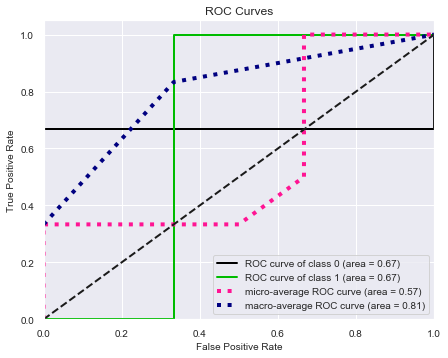

In [335]:
#Predicting probabilities for plotting the ROC curve
model_svm = SVC(kernel = 'linear', C = optimal_depth, probability=True)
model_svm.fit(train_frontal_x, train_y)
pred_proby = model_svm.predict_proba(test_frontal_x)

import scikitplot as skplt
import matplotlib.pyplot as plt
skplt.metrics.plot_roc(test_y, pred_proby, figsize=(7,5.5)) #Takes input as the ground truth labels and the predicted probabilities by algorithm
plt.savefig('frontals_LSVM_roc.jpg', dpi = 200)
plt.show()

## Random Forest

In [223]:
#Random Forest 
n_trees = range(1, 30)
depths = range(1, 30)
f1 = []
for depth in depths:
    for n_tree in n_trees:
        random_forest = RandomForestClassifier(n_estimators=n_tree, max_depth = depth, random_state= 0)
        scores = cross_validate(random_forest, train_frontal_x, train_y, cv=5, scoring = scoring)
        print ('\nDepth = ', depth, 'n_tree = ', n_tree)
        print ('Accuracy', scores['test_accuracy'].mean(), scores['test_accuracy'].std())
        print ('Precision', scores['test_precision'].mean(), scores['test_precision'].std())
        print ('Recall', scores['test_recall'].mean(), scores['test_recall'].std())
        print ('F1 Score', scores['test_f1_score'].mean(), scores['test_f1_score'].std())
        f1.append(scores['test_f1_score'].mean())
        #model accuracy for validation sets  
        #print (depth, 'Mean of 5 fold CV scores: ', np.mean(scores),' and Standard Deviation = ', np.std(scores))


Depth =  1 n_tree =  1
Accuracy 0.4666666666666666 0.3231786571610886
Precision 0.3 0.4
Recall 0.4 0.48989794855663565
F1 Score 0.3333333333333333 0.42163702135578396

Depth =  1 n_tree =  2
Accuracy 0.6333333333333333 0.37118429085533483
Precision 0.4 0.48989794855663565
Recall 0.4 0.48989794855663565
F1 Score 0.4 0.48989794855663565

Depth =  1 n_tree =  3
Accuracy 0.6833333333333333 0.18559214542766742
Precision 0.3333333333333333 0.42163702135578396
Recall 0.4 0.48989794855663565
F1 Score 0.36 0.44542114902640173

Depth =  1 n_tree =  4
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Depth =  1 n_tree =  5
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Depth =  1 n_tree =  6
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.2333333333333333 0.29059326290271154
Rec


Depth =  2 n_tree =  21
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Depth =  2 n_tree =  22
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Depth =  2 n_tree =  23
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Depth =  2 n_tree =  24
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Depth =  2 n_tree =  25
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Depth =  2 n_tree =  26
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Depth =  

Depth =  4 n_tree =  14
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Depth =  4 n_tree =  15
Accuracy 0.8833333333333332 0.1452966314513558
Precision 0.8 0.4
Recall 0.7 0.4
F1 Score 0.7333333333333333 0.38873012632302

Depth =  4 n_tree =  16
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Depth =  4 n_tree =  17
Accuracy 0.7333333333333333 0.2260776661041756
Precision 0.6 0.37416573867739417
Recall 0.7 0.4
F1 Score 0.6333333333333333 0.3711842908553348

Depth =  4 n_tree =  18
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Depth =  4 n_tree =  19
Accuracy 0.65 0.22607766610417562
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.46666666666666


Depth =  6 n_tree =  6
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Depth =  6 n_tree =  7
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.6 0.37416573867739417
Recall 0.7 0.4
F1 Score 0.5999999999999999 0.3265986323710904

Depth =  6 n_tree =  8
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Depth =  6 n_tree =  9
Accuracy 0.8 0.26666666666666666
Precision 0.6 0.48989794855663565
Recall 0.6 0.48989794855663565
F1 Score 0.6 0.48989794855663565

Depth =  6 n_tree =  10
Accuracy 0.6833333333333333 0.18559214542766742
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Depth =  6 n_tree =  11
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Depth =  6 n_tree =  1


Depth =  7 n_tree =  28
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Depth =  7 n_tree =  29
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Depth =  8 n_tree =  1
Accuracy 0.75 0.2472066162365221
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Depth =  8 n_tree =  2
Accuracy 0.7333333333333333 0.2260776661041756
Precision 0.4 0.48989794855663565
Recall 0.4 0.48989794855663565
F1 Score 0.4 0.48989794855663565

Depth =  8 n_tree =  3
Accuracy 0.6666666666666666 0.18257418583505536
Precision 0.3 0.39999999999999997
Recall 0.4 0.48989794855663565
F1 Score 0.3333333333333333 0.42163702135578396

Depth =  8 n_tree =  4
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.6 0.37416573867739417
Recall 0.7 0.4
F1 Score 0.5999999999999999 0.3265986


Depth =  9 n_tree =  20
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Depth =  9 n_tree =  21
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Depth =  9 n_tree =  22
Accuracy 0.8833333333333332 0.1452966314513558
Precision 0.8 0.4
Recall 0.7 0.4
F1 Score 0.7333333333333333 0.38873012632302

Depth =  9 n_tree =  23
Accuracy 0.6666666666666666 0.18257418583505536
Precision 0.4 0.37416573867739417
Recall 0.5 0.4472135954999579
F1 Score 0.4333333333333333 0.38873012632302

Depth =  9 n_tree =  24
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Depth =  9 n_tree =  25
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0


Depth =  11 n_tree =  13
Accuracy 0.8666666666666666 0.16329931618554522
Precision 0.6 0.48989794855663565
Recall 0.6 0.48989794855663565
F1 Score 0.6 0.48989794855663565

Depth =  11 n_tree =  14
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Depth =  11 n_tree =  15
Accuracy 0.65 0.22607766610417562
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Depth =  11 n_tree =  16
Accuracy 0.8833333333333332 0.1452966314513558
Precision 0.8 0.4
Recall 0.7 0.4
F1 Score 0.7333333333333333 0.38873012632302

Depth =  11 n_tree =  17
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Depth =  11 n_tree =  18
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Depth =  11 n_t


Depth =  13 n_tree =  6
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Depth =  13 n_tree =  7
Accuracy 0.8666666666666666 0.16329931618554522
Precision 0.7 0.4
Recall 0.8 0.4
F1 Score 0.7333333333333333 0.38873012632302

Depth =  13 n_tree =  8
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Depth =  13 n_tree =  9
Accuracy 0.75 0.2472066162365221
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Depth =  13 n_tree =  10
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Depth =  13 n_tree =  11
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Dept


Depth =  14 n_tree =  27
Accuracy 0.75 0.2472066162365221
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Depth =  14 n_tree =  28
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Depth =  14 n_tree =  29
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Depth =  15 n_tree =  1
Accuracy 0.6666666666666666 0.18257418583505536
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.3 0.39999999999999997

Depth =  15 n_tree =  2
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Depth =  15 n_tree =  3
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579


Depth =  16 n_tree =  18
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Depth =  16 n_tree =  19
Accuracy 0.8666666666666666 0.16329931618554522
Precision 0.6 0.48989794855663565
Recall 0.6 0.48989794855663565
F1 Score 0.6 0.48989794855663565

Depth =  16 n_tree =  20
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Depth =  16 n_tree =  21
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Depth =  16 n_tree =  22
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Depth =  16 n_tree =  23
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Depth =  16 n_tr


Depth =  18 n_tree =  10
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Depth =  18 n_tree =  11
Accuracy 0.65 0.22607766610417562
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Depth =  18 n_tree =  12
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Depth =  18 n_tree =  13
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Depth =  18 n_tree =  14
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Depth =  18 n_tree =  15
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Depth =  18 n_tr


Depth =  20 n_tree =  2
Accuracy 0.6333333333333333 0.19436506316151003
Precision 0.3 0.39999999999999997
Recall 0.4 0.48989794855663565
F1 Score 0.3333333333333333 0.42163702135578396

Depth =  20 n_tree =  3
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Depth =  20 n_tree =  4
Accuracy 0.7666666666666666 0.2
Precision 0.4 0.48989794855663565
Recall 0.4 0.48989794855663565
F1 Score 0.4 0.48989794855663565

Depth =  20 n_tree =  5
Accuracy 0.65 0.22607766610417562
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Depth =  20 n_tree =  6
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Depth =  20 n_tree =  7
Accuracy 0.6333333333333333 0.3711842908553348
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333


Depth =  21 n_tree =  22
Accuracy 0.8833333333333332 0.1452966314513558
Precision 0.8 0.4
Recall 0.7 0.4
F1 Score 0.7333333333333333 0.38873012632302

Depth =  21 n_tree =  23
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Depth =  21 n_tree =  24
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Depth =  21 n_tree =  25
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Depth =  21 n_tree =  26
Accuracy 0.8833333333333332 0.1452966314513558
Precision 0.8 0.4
Recall 0.7 0.4
F1 Score 0.7333333333333333 0.38873012632302

Depth =  21 n_tree =  27
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Depth 


Depth =  23 n_tree =  16
Accuracy 0.75 0.2472066162365221
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Depth =  23 n_tree =  17
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Depth =  23 n_tree =  18
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Depth =  23 n_tree =  19
Accuracy 0.8333333333333333 0.21081851067789195
Precision 0.7 0.4
Recall 0.8 0.4
F1 Score 0.7333333333333333 0.38873012632302

Depth =  23 n_tree =  20
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Depth =  23 n_tree =  21
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.6 0.37416573867739417
Recall 0.7 0.4
F1 Score 0.5999999999999999 0.3265986323710904

Depth =  23 n_tre


Depth =  25 n_tree =  9
Accuracy 0.8833333333333332 0.1452966314513558
Precision 0.8 0.4
Recall 0.7 0.4
F1 Score 0.7333333333333333 0.38873012632302

Depth =  25 n_tree =  10
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Depth =  25 n_tree =  11
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Depth =  25 n_tree =  12
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Depth =  25 n_tree =  13
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Depth =  25 n_tree =  14
Accuracy 0.9333333333333332 0.13333333333333336
Precision 0.8 0.4
Recall 0.8 0.4
F1 Score 0.8 0.4

Depth =  25 n_tree =  15
Accuracy 0


Depth =  27 n_tree =  3
Accuracy 0.7 0.26666666666666666
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Depth =  27 n_tree =  4
Accuracy 0.8833333333333332 0.1452966314513558
Precision 0.8 0.4
Recall 0.7 0.4
F1 Score 0.7333333333333333 0.38873012632302

Depth =  27 n_tree =  5
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.2 0.24494897427831783
Recall 0.3 0.39999999999999997
F1 Score 0.2333333333333333 0.2905932629027116

Depth =  27 n_tree =  6
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Depth =  27 n_tree =  7
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Depth =  27 n_tree =  8
Accuracy 0.8666666666666666 0.16329931618554522
Precision 0.6 0.48989794855663565
Recall 0.6 0.48989794855663565
F1 S


Depth =  28 n_tree =  24
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Depth =  28 n_tree =  25
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Depth =  28 n_tree =  26
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Depth =  28 n_tree =  27
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Depth =  28 n_tree =  28
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Depth =  28 n_tree =  29
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Depth =  29 n_tree =  1
Accuracy 0.61

In [236]:
#Finding the parameters where the maximum F1 score occured 
list_=[]
for depth in depths:
    for n_tree in n_trees:
        list_.append([depth, n_tree])
print ('The optimal parameters are ', list_[np.argmax(f1)])

The optimal parameters are  [23, 1]


In [251]:
#Defining the optimal parameters to test the model with tuned hyperparameters 
n_tree = 1
depth = 23
random_forest = RandomForestClassifier(n_estimators=n_tree, max_depth = depth, random_state=0)
random_forest.fit(train_frontal_x, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=23, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [252]:
#Testing of the model on the held out test set
pred_y = random_forest.predict(test_frontal_x)
print('On the test set: ', classification_report(test_y, pred_y))

On the test set:                precision    recall  f1-score   support

           0       0.60      1.00      0.75         3
           1       1.00      0.33      0.50         3

   micro avg       0.67      0.67      0.67         6
   macro avg       0.80      0.67      0.62         6
weighted avg       0.80      0.67      0.62         6



## Naive Bayes

In [208]:
#Gaussian Naive Bayes
gnb = GaussianNB()
scores = cross_validate(gnb, train_frontal_x, train_y, cv=5, scoring= scoring)
print ('Accuracy', scores['test_accuracy'].mean(), scores['test_accuracy'].std())
print ('Precision', scores['test_precision'].mean(), scores['test_precision'].std())
print ('Recall', scores['test_recall'].mean(), scores['test_recall'].std())
print ('F1 Score', scores['test_f1_score'].mean(), scores['test_f1_score'].std())
#model accuracy for validation sets  
#print (depth, 'Mean of 5 fold CV scores: ', np.mean(scores),' and Standard Deviation = ', np.std(scores))

Accuracy 0.9 0.2
Precision 0.9 0.2
Recall 1.0 0.0
F1 Score 0.9333333333333333 0.13333333333333336


In [210]:
#Since there are no parameters to be tuned, we simply fit on training set and test on the testing set
gnb.fit(train_frontal_x, train_y)

GaussianNB(priors=None, var_smoothing=1e-09)

In [211]:
#Testing of the model on the held out test set
pred_y = gnb.predict(test_frontal_x)
print('On the test set: ', classification_report(test_y, pred_y))

On the test set:                precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.75      1.00      0.86         3

   micro avg       0.83      0.83      0.83         6
   macro avg       0.88      0.83      0.83         6
weighted avg       0.88      0.83      0.83         6



## KNN

In [217]:
#K-nearest neighbours
depths = range(1, 10)
f1 = []

for k in depths:
    knn = KNeighborsClassifier(n_neighbors = k)
    scores = cross_validate(knn, train_frontal_x, train_y, cv=5, scoring = scoring)
    print ('\nk = ', k)
    print ('Accuracy', scores['test_accuracy'].mean(), scores['test_accuracy'].std())
    print ('Precision', scores['test_precision'].mean(), scores['test_precision'].std())
    print ('Recall', scores['test_recall'].mean(), scores['test_recall'].std())
    print ('F1 Score', scores['test_f1_score'].mean(), scores['test_f1_score'].std())
    f1.append(scores['test_f1_score'].mean())
    #model accuracy for validation sets  
    #print (k, 'Mean of 5 fold CV scores: ', np.mean(scores),' and Standard Deviation = ', np.std(scores))


k =  1
Accuracy 0.8666666666666666 0.16329931618554522
Precision 0.6 0.48989794855663565
Recall 0.6 0.48989794855663565
F1 Score 0.6 0.48989794855663565

k =  2
Accuracy 0.6666666666666666 0.18257418583505536
Precision 0.2 0.4
Recall 0.2 0.4
F1 Score 0.2 0.4

k =  3
Accuracy 0.75 0.2472066162365221
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

k =  4
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

k =  5
Accuracy 0.5 0.10540925533894598
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

k =  6
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

k =  7
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.2 0.4000000000000001
Recall 0.1 0.20000000000000004
F1 Score 0.13333333333333333 0.26666666666666666

k =  8
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

k =  9
A

In [219]:
#Finding the parameters where the maximum F1 score occured 
list_=[]
for depth in depths:
        list_.append({depth})
print ('The optimal parameters are ', list_[np.argmax(f1)])

The optimal parameters are  {1}


In [221]:
k = 1
knn = KNeighborsClassifier(n_neighbors = k)
knn.fit(train_frontal_x, train_y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform')

In [222]:
#Testing of the model on the held out test set
pred_y = knn.predict(test_frontal_x)
print('On the test set: ', classification_report(test_y, pred_y))

On the test set:                precision    recall  f1-score   support

           0       0.67      0.67      0.67         3
           1       0.67      0.67      0.67         3

   micro avg       0.67      0.67      0.67         6
   macro avg       0.67      0.67      0.67         6
weighted avg       0.67      0.67      0.67         6



## Decision Tree

In [265]:
#Decision Tree classifier 
depths = range(1, 30)
f1 = []

for depth in depths:
    decision_tree= DecisionTreeClassifier(max_depth = depth, random_state= 0)
    scores = cross_validate(decision_tree, train_frontal_x, train_y, cv=5, scoring= scoring)
    print ('\nDepth = ', depth)
    print ('Accuracy', scores['test_accuracy'].mean(), scores['test_accuracy'].std())
    print ('Precision', scores['test_precision'].mean(), scores['test_precision'].std())
    print ('Recall', scores['test_recall'].mean(), scores['test_recall'].std())
    print ('F1 Score', scores['test_f1_score'].mean(), scores['test_f1_score'].std())
    f1.append(scores['test_f1_score'].mean())
    #model accuracy for validation sets  
    #print (depth, 'Mean of 5 fold CV scores: ', np.mean(scores),' and Standard Deviation = ', np.std(scores))


Depth =  1
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Depth =  2
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Depth =  3
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Depth =  4
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Depth =  5
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Depth =  6
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Depth =  7
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Depth =  8
Accuracy 0.78333333333

In [269]:
#Finding the parameters where the maximum F1 score occured 
list_=[]
for depth in depths:
        list_.append({depth})
print ('The optimal parameters are ', list_[np.argmax(f1)])

The optimal parameters are  {1}


In [270]:
depth = 1
decision_tree= DecisionTreeClassifier(max_depth = depth, random_state=0)
decision_tree.fit(train_frontal_x, train_y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [271]:
#Testing of the model on the held out test set
pred_y = decision_tree.predict(test_frontal_x)
print('On the test set: ', classification_report(test_y, pred_y))

On the test set:                precision    recall  f1-score   support

           0       0.40      0.67      0.50         3
           1       0.00      0.00      0.00         3

   micro avg       0.33      0.33      0.33         6
   macro avg       0.20      0.33      0.25         6
weighted avg       0.20      0.33      0.25         6



## RBF SVM

In [276]:
#RBF kernel SVM
f1 = []
depths = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]

for depth in depths:
    model_svm_rbf = SVC(kernel = 'rbf', C = depth, gamma = 'auto')
    scores = cross_validate(model_svm_rbf, train_frontal_x, train_y, cv=5, scoring = scoring)
    print ('\nDepth = ', depth)
    print ('Accuracy', scores['test_accuracy'].mean(), scores['test_accuracy'].std())
    print ('Precision', scores['test_precision'].mean(), scores['test_precision'].std())
    print ('Recall', scores['test_recall'].mean(), scores['test_recall'].std())
    print ('F1 Score', scores['test_f1_score'].mean(), scores['test_f1_score'].std())
    f1.append(scores['test_f1_score'].mean())
    #model accuracy for validation sets  
    #print (depth, 'Mean of 5 fold CV scores: ', np.mean(scores),' and Standard Deviation = ', np.std(scores))


Depth =  0.1
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Depth =  0.2
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Depth =  0.3
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Depth =  0.4
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Depth =  0.5
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Depth =  0.6
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Depth =  0.7
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Depth =  0.8
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Depth =  1.0
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 

In [274]:
#Finding the parameters where the maximum F1 score occured 
list_=[]
for depth in depths:
        list_.append({depth})
print ('The optimal parameters are ', list_[np.argmax(f1)])

The optimal parameters are  {0.1}


In [277]:
depth = 1.0
model_svm_rbf = SVC(kernel = 'rbf', C = depth, gamma = 'auto')
model_svm_rbf.fit(train_frontal_x, train_y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [278]:
#Testing of the model on the held out test set
pred_y = model_svm_rbf.predict(test_frontal_x)
print('On the test set: ', classification_report(test_y, pred_y))

On the test set:                precision    recall  f1-score   support

           0       0.50      1.00      0.67         3
           1       0.00      0.00      0.00         3

   micro avg       0.50      0.50      0.50         6
   macro avg       0.25      0.50      0.33         6
weighted avg       0.25      0.50      0.33         6



## Logistic Regression

In [280]:
#Logistic Regression
depths = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0, 2, 3]
f1 = []

for depth in depths:
    model_logistic = LogisticRegression(random_state=0, solver='lbfgs', C = depth)
    scores = cross_validate(model_logistic, train_frontal_x, train_y, cv=5, scoring = scoring)
    print ('\nDepth = ', depth)
    print ('Accuracy', scores['test_accuracy'].mean(), scores['test_accuracy'].std())
    print ('Precision', scores['test_precision'].mean(), scores['test_precision'].std())
    print ('Recall', scores['test_recall'].mean(), scores['test_recall'].std())
    print ('F1 Score', scores['test_f1_score'].mean(), scores['test_f1_score'].std())
    f1.append(scores['test_f1_score'].mean())
    #model accuracy for validation sets  
    #print (depth, 'Mean of 5 fold CV scores: ', np.mean(scores),' and Standard Deviation = ', np.std(scores))


Depth =  0.1
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Depth =  0.2
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Depth =  0.3
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Depth =  0.4
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Depth =  0.5
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Depth =  0.6
Accuracy 0.6666666666666666 0.18257418583505536
Precision 0.2 0.4
Recall 0.2 0.4
F1 Score 0.2 0.4

Depth =  0.7
Accuracy 0.6666666666666666 0.18257418583505536
Precision 0.2 0.4
Recall 0.2 0.4
F1 Score 0.2 0.4

Depth =  0.8
Accuracy 0.6666666666666666 0.18257418583505536
Precision 0.2 0.4
Recall 0.2 0.4
F1 Score 0.2 0.4

Depth =  1.0
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0

In [281]:
#Finding the parameters where the maximum F1 score occured 
list_=[]
for depth in depths:
        list_.append({depth})
print ('The optimal parameters are ', list_[np.argmax(f1)])

The optimal parameters are  {3}


In [285]:
depth = 3
model_logistic = LogisticRegression(random_state=0, solver='lbfgs', C = depth)
model_logistic.fit(train_frontal_x, train_y)

LogisticRegression(C=3, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [286]:
#Testing of the model on the held out test set
pred_y = model_logistic.predict(test_frontal_x)
print('On the test set: ', classification_report(test_y, pred_y))

On the test set:                precision    recall  f1-score   support

           0       0.67      0.67      0.67         3
           1       0.67      0.67      0.67         3

   micro avg       0.67      0.67      0.67         6
   macro avg       0.67      0.67      0.67         6
weighted avg       0.67      0.67      0.67         6



## GBM

In [287]:
#GBM
n_trees =  range(1, 30)
lrs = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
f1 = []
for lr in lrs:
    for n_tree in n_trees:
        model = GradientBoostingClassifier(random_state = 10, n_estimators=n_tree, learning_rate=lr, min_samples_split= 2,
                                        min_samples_leaf= 3 ,max_depth= 3, max_features=None,
                                        subsample=1)
        scores = cross_validate(model, train_frontal_x, train_y, cv=5, scoring = scoring)
        print ('\nLearning rate = ', lr, 'n_tree = ',  n_tree)
        print ('Accuracy', scores['test_accuracy'].mean(), scores['test_accuracy'].std())
        print ('Precision', scores['test_precision'].mean(), scores['test_precision'].std())
        print ('Recall', scores['test_recall'].mean(), scores['test_recall'].std())
        print ('F1 Score', scores['test_f1_score'].mean(), scores['test_f1_score'].std())
        f1.append(scores['test_f1_score'].mean())
        #model accuracy for validation sets  
        #print (depth, 'Mean of 5 fold CV scores: ', np.mean(scores),' and Standard Deviation = ', np.std(scores)


Learning rate =  0.01 n_tree =  1
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Learning rate =  0.01 n_tree =  2
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Learning rate =  0.01 n_tree =  3
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Learning rate =  0.01 n_tree =  4
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Learning rate =  0.01 n_tree =  5
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Learning rate =  0.01 n_tree =  6
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Learning rate =  0.01 n_tree =  7
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Learning rate =  0.01 n_tree =  8
Accuracy 0.5666666666666667 0.0816


Learning rate =  0.05 n_tree =  23
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.05 n_tree =  24
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.05 n_tree =  25
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.05 n_tree =  26
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.05 n_tree =  27
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.05 n_tree =  28
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.44721


Learning rate =  0.2 n_tree =  14
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Learning rate =  0.2 n_tree =  15
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Learning rate =  0.2 n_tree =  16
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Learning rate =  0.2 n_tree =  17
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Learning rate =  0.2 n_tree =  18
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Learning rate =  0.2 n_tree =  19
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Learning rate =  0.2 n_tree =  20

Learning rate =  0.4 n_tree =  8
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.4 n_tree =  9
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.4 n_tree =  10
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.4 n_tree =  11
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.4 n_tree =  12
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.4 n_tree =  13
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.44721359549995

Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Learning rate =  0.6 n_tree =  1
Accuracy 0.6833333333333333 0.18559214542766742
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.6 n_tree =  2
Accuracy 0.6833333333333333 0.18559214542766742
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.6 n_tree =  3
Accuracy 0.6833333333333333 0.18559214542766742
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.6 n_tree =  4
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.6 n_tree =  5
Accuracy 0.65 0.22607766610417562
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.6 n_tree =  6
Accuracy 0.7166666666666666 0.16


Learning rate =  0.7 n_tree =  20
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Learning rate =  0.7 n_tree =  21
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Learning rate =  0.7 n_tree =  22
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Learning rate =  0.7 n_tree =  23
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Learning rate =  0.7 n_tree =  24
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Learning rate =  0.7 n_tree =  25
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Learning rate =  0.7 n_tree =  26


Learning rate =  0.9 n_tree =  11
Accuracy 0.6833333333333333 0.18559214542766742
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.9 n_tree =  12
Accuracy 0.6833333333333333 0.18559214542766742
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.9 n_tree =  13
Accuracy 0.6833333333333333 0.18559214542766742
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.9 n_tree =  14
Accuracy 0.6833333333333333 0.18559214542766742
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.9 n_tree =  15
Accuracy 0.6833333333333333 0.18559214542766742
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.9 n_tree =  16
Accuracy 0.6833333333333333 0.18559214542766742
Precision 0.5 0.44721359549


Learning rate =  1 n_tree =  29
Accuracy 0.6833333333333333 0.18559214542766742
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4


In [289]:
#Finding the parameters where the maximum F1 score occured 
list_=[]
for lr in lrs:
    for n_tree in n_trees:
        list_.append([lr, n_tree])
print ('The optimal parameters are ', list_[np.argmax(f1)])

The optimal parameters are  [0.2, 9]


In [290]:
n_tree =  9
lr = 0.2
model = GradientBoostingClassifier(random_state = 10, n_estimators=n_tree, learning_rate=lr, min_samples_split= 2,
                                        min_samples_leaf= 3 ,max_depth= 3, max_features=None,
                                        subsample=1)
model.fit(train_frontal_x, train_y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.2, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=3, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=9,
              n_iter_no_change=None, presort='auto', random_state=10,
              subsample=1, tol=0.0001, validation_fraction=0.1, verbose=0,
              warm_start=False)

In [291]:
#Testing of the model on the held out test set
pred_y = model.predict(test_frontal_x)
print('On the test set: ', classification_report(test_y, pred_y))

On the test set:                precision    recall  f1-score   support

           0       0.67      0.67      0.67         3
           1       0.67      0.67      0.67         3

   micro avg       0.67      0.67      0.67         6
   macro avg       0.67      0.67      0.67         6
weighted avg       0.67      0.67      0.67         6



## XGBoost

In [292]:
#XGBoost
n_trees = range(1, 30)
lrs = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
f1 = []
for lr in lrs:
    for n_tree in n_trees:
        model = XGBClassifier(learning_rate = lr, max_depth = 10, alpha = 10, n_estimators = n_tree,\
                              subsample = 0.3, random_state= 0)
        scores = cross_validate(model, train_frontal_x, train_y, cv=5, scoring = scoring)
        print ('\nLearning rate = ', lr, ' n_tree = ', n_tree)
        print ('Accuracy', scores['test_accuracy'].mean(), scores['test_accuracy'].std())
        print ('Precision', scores['test_precision'].mean(), scores['test_precision'].std())
        print ('Recall', scores['test_recall'].mean(), scores['test_recall'].std())
        print ('F1 Score', scores['test_f1_score'].mean(), scores['test_f1_score'].std())
        f1.append(scores['test_f1_score'].mean())
        #model accuracy for validation sets  
        #print (depth, 'Mean of 5 fold CV scores: ', np.mean(scores),' and Standard Deviation = ', np.std(scores)


Learning rate =  0.01  n_tree =  1
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.1 0.2
Recall 0.2 0.4
F1 Score 0.13333333333333333 0.26666666666666666

Learning rate =  0.01  n_tree =  2
Accuracy 0.5 0.10540925533894598
Precision 0.16666666666666666 0.21081851067789198
Recall 0.4 0.48989794855663565
F1 Score 0.2333333333333333 0.29059326290271154

Learning rate =  0.01  n_tree =  3
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.1 0.20000000000000004
Recall 0.2 0.4000000000000001
F1 Score 0.13333333333333333 0.26666666666666666

Learning rate =  0.01  n_tree =  4
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.1 0.20000000000000004
Recall 0.2 0.4000000000000001
F1 Score 0.13333333333333333 0.26666666666666666

Learning rate =  0.01  n_tree =  5
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Learning rate =  0.01  n_tree =  6
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.1 0.20000000


Learning rate =  0.05  n_tree =  29
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Learning rate =  0.1  n_tree =  1
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.1 0.2
Recall 0.2 0.4
F1 Score 0.13333333333333333 0.26666666666666666

Learning rate =  0.1  n_tree =  2
Accuracy 0.5 0.10540925533894598
Precision 0.16666666666666666 0.21081851067789198
Recall 0.4 0.48989794855663565
F1 Score 0.2333333333333333 0.29059326290271154

Learning rate =  0.1  n_tree =  3
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.1 0.20000000000000004
Recall 0.2 0.4000000000000001
F1 Score 0.13333333333333333 0.26666666666666666

Learning rate =  0.1  n_tree =  4
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.1 0.20000000000000004
Recall 0.2 0.4000000000000001
F1 Score 0.13333333333333333 0.26666666666666666

Learning rate =  0.1  n_tree =  5
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0


Learning rate =  0.2  n_tree =  27
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Learning rate =  0.2  n_tree =  28
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Learning rate =  0.2  n_tree =  29
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.1 0.2
Recall 0.2 0.4
F1 Score 0.13333333333333333 0.26666666666666666

Learning rate =  0.3  n_tree =  1
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.1 0.2
Recall 0.2 0.4
F1 Score 0.13333333333333333 0.26666666666666666

Learning rate =  0.3  n_tree =  2
Accuracy 0.5 0.10540925533894598
Precision 0.16666666666666666 0.21081851067789198
Recall 0.4 0.48989794855663565
F1 Score 0.2333333333333333 0.29059326290271154

Learning rate =  0.3  n_tree =  3
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.1 0.20000000000000004
Recall 0.2 0.4000000000000001
F1 Score 0.13333333333333333 0.26666666666666666

Learnin


Learning rate =  0.4  n_tree =  22
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Learning rate =  0.4  n_tree =  23
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.1 0.20000000000000004
Recall 0.2 0.4000000000000001
F1 Score 0.13333333333333333 0.26666666666666666

Learning rate =  0.4  n_tree =  24
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.1 0.20000000000000004
Recall 0.2 0.4000000000000001
F1 Score 0.13333333333333333 0.26666666666666666

Learning rate =  0.4  n_tree =  25
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.1 0.20000000000000004
Recall 0.2 0.4000000000000001
F1 Score 0.13333333333333333 0.26666666666666666

Learning rate =  0.4  n_tree =  26
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.1 0.20000000000000004
Recall 0.2 0.4000000000000001
F1 Score 0.13333333333333333 0.26666666666666666

Learning rate =  0.4  n_tree =  27
Accuracy 0.5666666666666667 0.081649658092


Learning rate =  0.6  n_tree =  13
Accuracy 0.5 0.10540925533894598
Precision 0.16666666666666666 0.21081851067789195
Recall 0.4 0.48989794855663565
F1 Score 0.2333333333333333 0.2905932629027116

Learning rate =  0.6  n_tree =  14
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.1 0.2
Recall 0.2 0.4
F1 Score 0.13333333333333333 0.26666666666666666

Learning rate =  0.6  n_tree =  15
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.1 0.2
Recall 0.2 0.4
F1 Score 0.13333333333333333 0.26666666666666666

Learning rate =  0.6  n_tree =  16
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Learning rate =  0.6  n_tree =  17
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Learning rate =  0.6  n_tree =  18
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Learning rate =  0.6  n_tree =  19
Accuracy 0.5666666666666667 0.081


Learning rate =  0.8  n_tree =  4
Accuracy 0.5 0.10540925533894598
Precision 0.16666666666666666 0.21081851067789198
Recall 0.4 0.48989794855663565
F1 Score 0.2333333333333333 0.29059326290271154

Learning rate =  0.8  n_tree =  5
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Learning rate =  0.8  n_tree =  6
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.0 0.0
Recall 0.0 0.0
F1 Score 0.0 0.0

Learning rate =  0.8  n_tree =  7
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.2 0.24494897427831783
Recall 0.4 0.48989794855663565
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.8  n_tree =  8
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.1 0.2
Recall 0.2 0.4
F1 Score 0.13333333333333333 0.26666666666666666

Learning rate =  0.8  n_tree =  9
Accuracy 0.5 0.10540925533894598
Precision 0.06666666666666667 0.13333333333333333
Recall 0.2 0.4000000000000001
F1 Score 0.1 0.2000000000000


Learning rate =  0.9  n_tree =  22
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.1 0.20000000000000004
Recall 0.2 0.4000000000000001
F1 Score 0.13333333333333333 0.26666666666666666

Learning rate =  0.9  n_tree =  23
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.1 0.20000000000000004
Recall 0.2 0.4000000000000001
F1 Score 0.13333333333333333 0.26666666666666666

Learning rate =  0.9  n_tree =  24
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.1 0.20000000000000004
Recall 0.2 0.4000000000000001
F1 Score 0.13333333333333333 0.26666666666666666

Learning rate =  0.9  n_tree =  25
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.1 0.20000000000000004
Recall 0.2 0.4000000000000001
F1 Score 0.13333333333333333 0.26666666666666666

Learning rate =  0.9  n_tree =  26
Accuracy 0.5666666666666667 0.08164965809277258
Precision 0.2 0.24494897427831783
Recall 0.4 0.48989794855663565
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate 

In [293]:
#Finding the parameters where the maximum F1 score occured 
list_=[]
for lr in lrs:
    for n_tree in n_trees:
        list_.append([lr, n_tree])
print ('The optimal parameters are ', list_[np.argmax(f1)])

The optimal parameters are  [0.8, 13]


In [294]:
lr = 0.8
n_tree = 13
model = XGBClassifier(learning_rate = lr, max_depth = 10, alpha = 10, n_estimators = n_tree, subsample = 0.3, random_state= 0)
model.fit(train_frontal_x, train_y)

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.8, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=13,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.3)

In [296]:
#Testing of the model on the held out test set
pred_y = model.predict(test_frontal_x)
print('On the test set: ', classification_report(test_y, pred_y))

On the test set:                precision    recall  f1-score   support

           0       0.50      1.00      0.67         3
           1       0.00      0.00      0.00         3

   micro avg       0.50      0.50      0.50         6
   macro avg       0.25      0.50      0.33         6
weighted avg       0.25      0.50      0.33         6



## Adaboost

In [299]:
#Adaboost
n_trees = range(1, 30) #[4] #
depths = range(1, 30)
lrs = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1] #[0.05] #
f1 = []
for lr in lrs:
    for depth in depths:
        for tree in n_trees:
            model = AdaBoostClassifier(base_estimator=RandomForestClassifier(n_estimators=tree, max_depth = depth, random_state = 0), n_estimators=3, learning_rate=lr, random_state=10)
            scores = cross_validate(model, train_frontal_x, train_y, cv=5, scoring = scoring)
            print ('\nLearning rate = ', lr, 'depth = ', depth, 'n_tree = ', tree)
            print ('Accuracy', scores['test_accuracy'].mean(), scores['test_accuracy'].std())
            print ('Precision', scores['test_precision'].mean(), scores['test_precision'].std())
            print ('Recall', scores['test_recall'].mean(), scores['test_recall'].std())
            print ('F1 Score', scores['test_f1_score'].mean(), scores['test_f1_score'].std())
            f1.append(scores['test_f1_score'].mean())
            #model accuracy for validation sets  
            #print (depth, 'Mean of 5 fold CV scores: ', np.mean(scores),' and Standard Deviation = ', np.std(scores)


Learning rate =  0.01 depth =  1 n_tree =  1
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.01 depth =  1 n_tree =  2
Accuracy 0.8833333333333332 0.1452966314513558
Precision 0.8 0.4
Recall 0.7 0.4
F1 Score 0.7333333333333333 0.38873012632302

Learning rate =  0.01 depth =  1 n_tree =  3
Accuracy 0.8666666666666666 0.16329931618554522
Precision 0.6 0.48989794855663565
Recall 0.6 0.48989794855663565
F1 Score 0.6 0.48989794855663565

Learning rate =  0.01 depth =  1 n_tree =  4
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.01 depth =  1 n_tree =  5
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.


Learning rate =  0.01 depth =  2 n_tree =  15
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.01 depth =  2 n_tree =  16
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.01 depth =  2 n_tree =  17
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.01 depth =  2 n_tree =  18
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.01 depth =  2 n_tree =  19
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4


Learning rate =  0.01 depth =  3 n_tree =  27
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.01 depth =  3 n_tree =  28
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.01 depth =  3 n_tree =  29
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.01 depth =  4 n_tree =  1
Accuracy 0.7666666666666666 0.2
Precision 0.4 0.48989794855663565
Recall 0.4 0.48989794855663565
F1 Score 0.4 0.48989794855663565

Learning rate =  0.01 depth =  4 n_tree =  2
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rat


Learning rate =  0.01 depth =  5 n_tree =  12
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.01 depth =  5 n_tree =  13
Accuracy 0.8666666666666666 0.16329931618554522
Precision 0.6 0.48989794855663565
Recall 0.6 0.48989794855663565
F1 Score 0.6 0.48989794855663565

Learning rate =  0.01 depth =  5 n_tree =  14
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.01 depth =  5 n_tree =  15
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.01 depth =  5 n_tree =  16
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0


Learning rate =  0.01 depth =  6 n_tree =  24
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.01 depth =  6 n_tree =  25
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.01 depth =  6 n_tree =  26
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.01 depth =  6 n_tree =  27
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.01 depth =  6 n_tree =  28
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.


Learning rate =  0.01 depth =  8 n_tree =  8
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.01 depth =  8 n_tree =  9
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.01 depth =  8 n_tree =  10
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.01 depth =  8 n_tree =  11
Accuracy 0.8 0.26666666666666666
Precision 0.6 0.48989794855663565
Recall 0.6 0.48989794855663565
F1 Score 0.6 0.48989794855663565

Learning rate =  0.01 depth =  8 n_tree =  12
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.01 depth =  8 n_tree =  13
A


Learning rate =  0.01 depth =  9 n_tree =  21
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.01 depth =  9 n_tree =  22
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.01 depth =  9 n_tree =  23
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.01 depth =  9 n_tree =  24
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.01 depth =  9 n_tree =  25
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.33


Learning rate =  0.01 depth =  11 n_tree =  4
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.01 depth =  11 n_tree =  5
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.01 depth =  11 n_tree =  6
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.01 depth =  11 n_tree =  7
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.01 depth =  11 n_tree =  8
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666

Learning rate =  0.01 depth =  12 n_tree =  16
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.01 depth =  12 n_tree =  17
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.01 depth =  12 n_tree =  18
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.01 depth =  12 n_tree =  19
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.01 depth =  12 n_tree =  20
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.42163702135


Learning rate =  0.01 depth =  13 n_tree =  28
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.01 depth =  13 n_tree =  29
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.01 depth =  14 n_tree =  1
Accuracy 0.7666666666666666 0.2
Precision 0.4 0.48989794855663565
Recall 0.4 0.48989794855663565
F1 Score 0.4 0.48989794855663565

Learning rate =  0.01 depth =  14 n_tree =  2
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.01 depth =  14 n_tree =  3
Accuracy 0.8833333333333332 0.1452966314513558
Precision 0.8 0.4
Recall 0.7 0.4
F1 Score 0.7333333333333333 0.38873012632302

Learning rate =  0.01 depth =  14 n_tree =  


Learning rate =  0.01 depth =  15 n_tree =  12
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.01 depth =  15 n_tree =  13
Accuracy 0.8666666666666666 0.16329931618554522
Precision 0.6 0.48989794855663565
Recall 0.6 0.48989794855663565
F1 Score 0.6 0.48989794855663565

Learning rate =  0.01 depth =  15 n_tree =  14
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.01 depth =  15 n_tree =  15
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.01 depth =  15 n_tree =  16
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333


Learning rate =  0.01 depth =  16 n_tree =  24
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.01 depth =  16 n_tree =  25
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.01 depth =  16 n_tree =  26
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.01 depth =  16 n_tree =  27
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.01 depth =  16 n_tree =  28
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Sco


Learning rate =  0.01 depth =  18 n_tree =  8
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.01 depth =  18 n_tree =  9
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.01 depth =  18 n_tree =  10
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.01 depth =  18 n_tree =  11
Accuracy 0.8 0.26666666666666666
Precision 0.6 0.48989794855663565
Recall 0.6 0.48989794855663565
F1 Score 0.6 0.48989794855663565

Learning rate =  0.01 depth =  18 n_tree =  12
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.01 depth =  18 n_tree =


Learning rate =  0.01 depth =  19 n_tree =  21
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.01 depth =  19 n_tree =  22
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.01 depth =  19 n_tree =  23
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.01 depth =  19 n_tree =  24
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.01 depth =  19 n_tree =  25
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score


Learning rate =  0.01 depth =  21 n_tree =  4
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.01 depth =  21 n_tree =  5
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.01 depth =  21 n_tree =  6
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.01 depth =  21 n_tree =  7
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.01 depth =  21 n_tree =  8
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666


Learning rate =  0.01 depth =  22 n_tree =  16
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.01 depth =  22 n_tree =  17
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.01 depth =  22 n_tree =  18
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.01 depth =  22 n_tree =  19
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.01 depth =  22 n_tree =  20
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213


Learning rate =  0.01 depth =  23 n_tree =  28
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.01 depth =  23 n_tree =  29
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.01 depth =  24 n_tree =  1
Accuracy 0.7666666666666666 0.2
Precision 0.4 0.48989794855663565
Recall 0.4 0.48989794855663565
F1 Score 0.4 0.48989794855663565

Learning rate =  0.01 depth =  24 n_tree =  2
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.01 depth =  24 n_tree =  3
Accuracy 0.8833333333333332 0.1452966314513558
Precision 0.8 0.4
Recall 0.7 0.4
F1 Score 0.7333333333333333 0.38873012632302

Learning rate =  0.01 depth =  24 n_tree =  

Learning rate =  0.01 depth =  25 n_tree =  12
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.01 depth =  25 n_tree =  13
Accuracy 0.8666666666666666 0.16329931618554522
Precision 0.6 0.48989794855663565
Recall 0.6 0.48989794855663565
F1 Score 0.6 0.48989794855663565

Learning rate =  0.01 depth =  25 n_tree =  14
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.01 depth =  25 n_tree =  15
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.01 depth =  25 n_tree =  16
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.33333333333333


Learning rate =  0.01 depth =  26 n_tree =  24
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.01 depth =  26 n_tree =  25
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.01 depth =  26 n_tree =  26
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.01 depth =  26 n_tree =  27
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.01 depth =  26 n_tree =  28
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Sco

Learning rate =  0.01 depth =  28 n_tree =  7
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.01 depth =  28 n_tree =  8
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.01 depth =  28 n_tree =  9
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.01 depth =  28 n_tree =  10
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.01 depth =  28 n_tree =  11
Accuracy 0.8 0.26666666666666666
Precision 0.6 0.48989794855663565
Recall 0.6 0.48989794855663565
F1 Score 0.6 0.48989794855663565

Learning rate =  0.01 depth =  28 n_tree =  

F1 Score 0.4666666666666666 0.4

Learning rate =  0.01 depth =  29 n_tree =  20
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.01 depth =  29 n_tree =  21
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.01 depth =  29 n_tree =  22
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.01 depth =  29 n_tree =  23
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.01 depth =  29 n_tree =  24
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 


Learning rate =  0.05 depth =  2 n_tree =  4
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.05 depth =  2 n_tree =  5
Accuracy 0.8833333333333332 0.1452966314513558
Precision 0.8 0.4
Recall 0.7 0.4
F1 Score 0.7333333333333333 0.38873012632302

Learning rate =  0.05 depth =  2 n_tree =  6
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.05 depth =  2 n_tree =  7
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.05 depth =  2 n_tree =  8
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.05 de

F1 Score 0.4666666666666666 0.4

Learning rate =  0.05 depth =  3 n_tree =  18
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.05 depth =  3 n_tree =  19
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.05 depth =  3 n_tree =  20
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.05 depth =  3 n_tree =  21
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.05 depth =  3 n_tree =  22
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.399999999999999


Learning rate =  0.05 depth =  5 n_tree =  2
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.05 depth =  5 n_tree =  3
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.05 depth =  5 n_tree =  4
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.05 depth =  5 n_tree =  5
Accuracy 0.8833333333333332 0.1452966314513558
Precision 0.8 0.4
Recall 0.7 0.4
F1 Score 0.7333333333333333 0.38873012632302

Learning rate =  0.05 depth =  5 n_tree =  6
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning


Learning rate =  0.05 depth =  6 n_tree =  16
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.05 depth =  6 n_tree =  17
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.05 depth =  6 n_tree =  18
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.05 depth =  6 n_tree =  19
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.05 depth =  6 n_tree =  20
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.421637021355783


Learning rate =  0.05 depth =  7 n_tree =  28
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.05 depth =  7 n_tree =  29
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.05 depth =  8 n_tree =  1
Accuracy 0.7333333333333333 0.2260776661041756
Precision 0.4 0.48989794855663565
Recall 0.4 0.48989794855663565
F1 Score 0.4 0.48989794855663565

Learning rate =  0.05 depth =  8 n_tree =  2
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.05 depth =  8 n_tree =  3
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125




Learning rate =  0.05 depth =  9 n_tree =  12
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.05 depth =  9 n_tree =  13
Accuracy 0.8666666666666666 0.16329931618554522
Precision 0.6 0.48989794855663565
Recall 0.6 0.48989794855663565
F1 Score 0.6 0.48989794855663565

Learning rate =  0.05 depth =  9 n_tree =  14
Accuracy 0.8833333333333332 0.1452966314513558
Precision 0.8 0.4
Recall 0.7 0.4
F1 Score 0.7333333333333333 0.38873012632302

Learning rate =  0.05 depth =  9 n_tree =  15
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.05 depth =  9 n_tree =  16
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =


Learning rate =  0.05 depth =  10 n_tree =  24
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.05 depth =  10 n_tree =  25
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.05 depth =  10 n_tree =  26
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.05 depth =  10 n_tree =  27
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.05 depth =  10 n_tree =  28
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Sco


Learning rate =  0.05 depth =  12 n_tree =  8
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.05 depth =  12 n_tree =  9
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.05 depth =  12 n_tree =  10
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.05 depth =  12 n_tree =  11
Accuracy 0.8 0.26666666666666666
Precision 0.6 0.48989794855663565
Recall 0.6 0.48989794855663565
F1 Score 0.6 0.48989794855663565

Learning rate =  0.05 depth =  12 n_tree =  12
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.05 dept


Learning rate =  0.05 depth =  13 n_tree =  21
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.05 depth =  13 n_tree =  22
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.05 depth =  13 n_tree =  23
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.05 depth =  13 n_tree =  24
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.05 depth =  13 n_tree =  25
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score


Learning rate =  0.05 depth =  15 n_tree =  4
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.05 depth =  15 n_tree =  5
Accuracy 0.8833333333333332 0.1452966314513558
Precision 0.8 0.4
Recall 0.7 0.4
F1 Score 0.7333333333333333 0.38873012632302

Learning rate =  0.05 depth =  15 n_tree =  6
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.05 depth =  15 n_tree =  7
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.05 depth =  15 n_tree =  8
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Lea


Learning rate =  0.05 depth =  16 n_tree =  17
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.05 depth =  16 n_tree =  18
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.05 depth =  16 n_tree =  19
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.05 depth =  16 n_tree =  20
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.05 depth =  16 n_tree =  21
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.452155332208


Learning rate =  0.05 depth =  17 n_tree =  29
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.05 depth =  18 n_tree =  1
Accuracy 0.7333333333333333 0.2260776661041756
Precision 0.4 0.48989794855663565
Recall 0.4 0.48989794855663565
F1 Score 0.4 0.48989794855663565

Learning rate =  0.05 depth =  18 n_tree =  2
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.05 depth =  18 n_tree =  3
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.05 depth =  18 n_tree =  4
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125


Learning rate =  0.05 depth =  19 n_tree =  13
Accuracy 0.8666666666666666 0.16329931618554522
Precision 0.6 0.48989794855663565
Recall 0.6 0.48989794855663565
F1 Score 0.6 0.48989794855663565

Learning rate =  0.05 depth =  19 n_tree =  14
Accuracy 0.8833333333333332 0.1452966314513558
Precision 0.8 0.4
Recall 0.7 0.4
F1 Score 0.7333333333333333 0.38873012632302

Learning rate =  0.05 depth =  19 n_tree =  15
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.05 depth =  19 n_tree =  16
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.05 depth =  19 n_tree =  17
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.05 dept


Learning rate =  0.05 depth =  20 n_tree =  25
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.05 depth =  20 n_tree =  26
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.05 depth =  20 n_tree =  27
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.05 depth =  20 n_tree =  28
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.05 depth =  20 n_tree =  29
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Scor


Learning rate =  0.05 depth =  22 n_tree =  8
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.05 depth =  22 n_tree =  9
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.05 depth =  22 n_tree =  10
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.05 depth =  22 n_tree =  11
Accuracy 0.8 0.26666666666666666
Precision 0.6 0.48989794855663565
Recall 0.6 0.48989794855663565
F1 Score 0.6 0.48989794855663565

Learning rate =  0.05 depth =  22 n_tree =  12
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.05 dept


Learning rate =  0.05 depth =  23 n_tree =  21
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.05 depth =  23 n_tree =  22
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.05 depth =  23 n_tree =  23
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.05 depth =  23 n_tree =  24
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.05 depth =  23 n_tree =  25
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score

Learning rate =  0.05 depth =  25 n_tree =  4
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.05 depth =  25 n_tree =  5
Accuracy 0.8833333333333332 0.1452966314513558
Precision 0.8 0.4
Recall 0.7 0.4
F1 Score 0.7333333333333333 0.38873012632302

Learning rate =  0.05 depth =  25 n_tree =  6
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.05 depth =  25 n_tree =  7
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.05 depth =  25 n_tree =  8
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Lear


Learning rate =  0.05 depth =  26 n_tree =  17
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.05 depth =  26 n_tree =  18
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.05 depth =  26 n_tree =  19
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.05 depth =  26 n_tree =  20
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.05 depth =  26 n_tree =  21
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.452155332208


Learning rate =  0.05 depth =  27 n_tree =  29
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.05 depth =  28 n_tree =  1
Accuracy 0.7333333333333333 0.2260776661041756
Precision 0.4 0.48989794855663565
Recall 0.4 0.48989794855663565
F1 Score 0.4 0.48989794855663565

Learning rate =  0.05 depth =  28 n_tree =  2
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.05 depth =  28 n_tree =  3
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.05 depth =  28 n_tree =  4
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125


Learning rate =  0.05 depth =  29 n_tree =  14
Accuracy 0.8833333333333332 0.1452966314513558
Precision 0.8 0.4
Recall 0.7 0.4
F1 Score 0.7333333333333333 0.38873012632302

Learning rate =  0.05 depth =  29 n_tree =  15
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.05 depth =  29 n_tree =  16
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.05 depth =  29 n_tree =  17
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.05 depth =  29 n_tree =  18
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning ra


Learning rate =  0.1 depth =  1 n_tree =  28
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.1 depth =  1 n_tree =  29
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.1 depth =  2 n_tree =  1
Accuracy 0.6666666666666666 0.18257418583505536
Precision 0.2 0.4000000000000001
Recall 0.2 0.4000000000000001
F1 Score 0.2 0.4000000000000001

Learning rate =  0.1 depth =  2 n_tree =  2
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.1 depth =  2 n_tree =  3
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Learning rate =  0.1 depth =  2 n_tree =  4
Accuracy 0.716


Learning rate =  0.1 depth =  3 n_tree =  13
Accuracy 0.8666666666666666 0.16329931618554522
Precision 0.6 0.48989794855663565
Recall 0.6 0.48989794855663565
F1 Score 0.6 0.48989794855663565

Learning rate =  0.1 depth =  3 n_tree =  14
Accuracy 0.8833333333333332 0.1452966314513558
Precision 0.8 0.4
Recall 0.7 0.4
F1 Score 0.7333333333333333 0.38873012632302

Learning rate =  0.1 depth =  3 n_tree =  15
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.1 depth =  3 n_tree =  16
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.1 depth =  3 n_tree =  17
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.1 depth =  3 n_tr


Learning rate =  0.1 depth =  4 n_tree =  26
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.1 depth =  4 n_tree =  27
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.1 depth =  4 n_tree =  28
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.1 depth =  4 n_tree =  29
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.1 depth =  5 n_tree =  1
Accuracy 0.6666666666666666 0.18257418583505536
Precision 0.2 0.4000000000000001
Recall 0.2 0.4000000000000001
F1 Score 0.2 0.4000000000000001

Le


Learning rate =  0.1 depth =  6 n_tree =  10
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.1 depth =  6 n_tree =  11
Accuracy 0.8 0.26666666666666666
Precision 0.6 0.48989794855663565
Recall 0.6 0.48989794855663565
F1 Score 0.6 0.48989794855663565

Learning rate =  0.1 depth =  6 n_tree =  12
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.1 depth =  6 n_tree =  13
Accuracy 0.8666666666666666 0.16329931618554522
Precision 0.6 0.48989794855663565
Recall 0.6 0.48989794855663565
F1 Score 0.6 0.48989794855663565

Learning rate =  0.1 depth =  6 n_tree =  14
Accuracy 0.8833333333333332 0.1452966314513558
Precision 0.8 0.4
Recall 0.7 0.4
F1 Score 0.7333333333333333 0.38873012632302

Learning rate =  0.1 depth =  6 n_tree =  15
Accuracy 0.816666666


Learning rate =  0.1 depth =  7 n_tree =  24
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.1 depth =  7 n_tree =  25
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.1 depth =  7 n_tree =  26
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.1 depth =  7 n_tree =  27
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.1 depth =  7 n_tree =  28
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666


Learning rate =  0.1 depth =  9 n_tree =  9
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.1 depth =  9 n_tree =  10
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.1 depth =  9 n_tree =  11
Accuracy 0.8 0.26666666666666666
Precision 0.6 0.48989794855663565
Recall 0.6 0.48989794855663565
F1 Score 0.6 0.48989794855663565

Learning rate =  0.1 depth =  9 n_tree =  12
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.1 depth =  9 n_tree =  13
Accuracy 0.8666666666666666 0.16329931618554522
Precision 0.6 0.48989794855663565
Recall 0.6 0.48989794855663565
F1 Score 0.6 0.48989794855663565

Learning rate =  0.1 depth =  9 n_tree =  14
Acc


Learning rate =  0.1 depth =  10 n_tree =  22
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.1 depth =  10 n_tree =  23
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.1 depth =  10 n_tree =  24
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.1 depth =  10 n_tree =  25
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.1 depth =  10 n_tree =  26
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3


Learning rate =  0.1 depth =  12 n_tree =  6
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.1 depth =  12 n_tree =  7
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.1 depth =  12 n_tree =  8
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.1 depth =  12 n_tree =  9
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.1 depth =  12 n_tree =  10
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.1 depth =  12 n_tr


Learning rate =  0.1 depth =  13 n_tree =  19
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.1 depth =  13 n_tree =  20
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.1 depth =  13 n_tree =  21
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.1 depth =  13 n_tree =  22
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.1 depth =  13 n_tree =  23
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.


Learning rate =  0.1 depth =  15 n_tree =  4
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.1 depth =  15 n_tree =  5
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.1 depth =  15 n_tree =  6
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.1 depth =  15 n_tree =  7
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.1 depth =  15 n_tree =  8
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.1 d


Learning rate =  0.1 depth =  16 n_tree =  17
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.1 depth =  16 n_tree =  18
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.1 depth =  16 n_tree =  19
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.1 depth =  16 n_tree =  20
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.1 depth =  16 n_tree =  21
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125


Learning rate =  0.1 depth =  18 n_tree =  2
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.1 depth =  18 n_tree =  3
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Learning rate =  0.1 depth =  18 n_tree =  4
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.1 depth =  18 n_tree =  5
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.1 depth =  18 n_tree =  6
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.1 de


Learning rate =  0.1 depth =  19 n_tree =  16
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.1 depth =  19 n_tree =  17
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.1 depth =  19 n_tree =  18
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.1 depth =  19 n_tree =  19
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.1 depth =  19 n_tree =  20
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.421637021355783


Learning rate =  0.1 depth =  20 n_tree =  29
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.1 depth =  21 n_tree =  1
Accuracy 0.6666666666666666 0.18257418583505536
Precision 0.2 0.4000000000000001
Recall 0.2 0.4000000000000001
F1 Score 0.2 0.4000000000000001

Learning rate =  0.1 depth =  21 n_tree =  2
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.1 depth =  21 n_tree =  3
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Learning rate =  0.1 depth =  21 n_tree =  4
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.1 depth =  21 n_tree =  5
Accuracy 


Learning rate =  0.1 depth =  22 n_tree =  14
Accuracy 0.8833333333333332 0.1452966314513558
Precision 0.8 0.4
Recall 0.7 0.4
F1 Score 0.7333333333333333 0.38873012632302

Learning rate =  0.1 depth =  22 n_tree =  15
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.1 depth =  22 n_tree =  16
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.1 depth =  22 n_tree =  17
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.1 depth =  22 n_tree =  18
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate = 


Learning rate =  0.1 depth =  23 n_tree =  27
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.1 depth =  23 n_tree =  28
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.1 depth =  23 n_tree =  29
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.1 depth =  24 n_tree =  1
Accuracy 0.6666666666666666 0.18257418583505536
Precision 0.2 0.4000000000000001
Recall 0.2 0.4000000000000001
F1 Score 0.2 0.4000000000000001

Learning rate =  0.1 depth =  24 n_tree =  2
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125



Learning rate =  0.1 depth =  25 n_tree =  12
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.1 depth =  25 n_tree =  13
Accuracy 0.8666666666666666 0.16329931618554522
Precision 0.6 0.48989794855663565
Recall 0.6 0.48989794855663565
F1 Score 0.6 0.48989794855663565

Learning rate =  0.1 depth =  25 n_tree =  14
Accuracy 0.8833333333333332 0.1452966314513558
Precision 0.8 0.4
Recall 0.7 0.4
F1 Score 0.7333333333333333 0.38873012632302

Learning rate =  0.1 depth =  25 n_tree =  15
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.1 depth =  25 n_tree =  16
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =


Learning rate =  0.1 depth =  26 n_tree =  25
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.1 depth =  26 n_tree =  26
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.1 depth =  26 n_tree =  27
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.1 depth =  26 n_tree =  28
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.1 depth =  26 n_tree =  29
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4


Learning rate =  0.1 depth =  28 n_tree =  10
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.1 depth =  28 n_tree =  11
Accuracy 0.8 0.26666666666666666
Precision 0.6 0.48989794855663565
Recall 0.6 0.48989794855663565
F1 Score 0.6 0.48989794855663565

Learning rate =  0.1 depth =  28 n_tree =  12
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.1 depth =  28 n_tree =  13
Accuracy 0.8666666666666666 0.16329931618554522
Precision 0.6 0.48989794855663565
Recall 0.6 0.48989794855663565
F1 Score 0.6 0.48989794855663565

Learning rate =  0.1 depth =  28 n_tree =  14
Accuracy 0.8833333333333332 0.1452966314513558
Precision 0.8 0.4
Recall 0.7 0.4
F1 Score 0.7333333333333333 0.38873012632302

Learning rate =  0.1 depth =  28 n_tree =  15
Accuracy 0.816


Learning rate =  0.1 depth =  29 n_tree =  23
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.1 depth =  29 n_tree =  24
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.1 depth =  29 n_tree =  25
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.1 depth =  29 n_tree =  26
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.1 depth =  29 n_tree =  27
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.2


Learning rate =  0.2 depth =  2 n_tree =  8
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.2 depth =  2 n_tree =  9
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.2 depth =  2 n_tree =  10
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.2 depth =  2 n_tree =  11
Accuracy 0.8 0.26666666666666666
Precision 0.6 0.48989794855663565
Recall 0.6 0.48989794855663565
F1 Score 0.6 0.48989794855663565

Learning rate =  0.2 depth =  2 n_tree =  12
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.2 depth =  2 n_tree =  13
Accurac


Learning rate =  0.2 depth =  3 n_tree =  21
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.2 depth =  3 n_tree =  22
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.2 depth =  3 n_tree =  23
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.2 depth =  3 n_tree =  24
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.2 depth =  3 n_tree =  25
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333


Learning rate =  0.2 depth =  5 n_tree =  6
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.2 depth =  5 n_tree =  7
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.2 depth =  5 n_tree =  8
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.2 depth =  5 n_tree =  9
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.2 depth =  5 n_tree =  10
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.2 depth =  5 n_tree =  11
Accuracy 0.8 


Learning rate =  0.2 depth =  6 n_tree =  20
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.2 depth =  6 n_tree =  21
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.2 depth =  6 n_tree =  22
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.2 depth =  6 n_tree =  23
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.2 depth =  6 n_tree =  24
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333


Learning rate =  0.2 depth =  8 n_tree =  4
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Learning rate =  0.2 depth =  8 n_tree =  5
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.2 depth =  8 n_tree =  6
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.2 depth =  8 n_tree =  7
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.2 depth =  8 n_tree =  8
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.2 depth =  8 n_tree =  9
Accuracy 0.766


Learning rate =  0.2 depth =  9 n_tree =  17
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.2 depth =  9 n_tree =  18
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.2 depth =  9 n_tree =  19
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.2 depth =  9 n_tree =  20
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.2 depth =  9 n_tree =  21
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Lea


Learning rate =  0.2 depth =  10 n_tree =  29
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.2 depth =  11 n_tree =  1
Accuracy 0.8333333333333333 0.21081851067789195
Precision 0.6 0.48989794855663565
Recall 0.6 0.48989794855663565
F1 Score 0.6 0.48989794855663565

Learning rate =  0.2 depth =  11 n_tree =  2
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.2 depth =  11 n_tree =  3
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.2 depth =  11 n_tree =  4
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Learning rate =  0.2 depth =  11


Learning rate =  0.2 depth =  12 n_tree =  14
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.2 depth =  12 n_tree =  15
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.2 depth =  12 n_tree =  16
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.2 depth =  12 n_tree =  17
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.2 depth =  12 n_tree =  18
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.


Learning rate =  0.2 depth =  13 n_tree =  26
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.2 depth =  13 n_tree =  27
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.2 depth =  13 n_tree =  28
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.2 depth =  13 n_tree =  29
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.2 depth =  14 n_tree =  1
Accuracy 0.8333333333333333 0.21081851067789195
Precision 0.6 0.48989794855663565
Recall 0.6 0.48989794855663565
F1 Score 0.6 0.4898979485566


Learning rate =  0.2 depth =  15 n_tree =  10
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.2 depth =  15 n_tree =  11
Accuracy 0.8 0.26666666666666666
Precision 0.6 0.48989794855663565
Recall 0.6 0.48989794855663565
F1 Score 0.6 0.48989794855663565

Learning rate =  0.2 depth =  15 n_tree =  12
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.2 depth =  15 n_tree =  13
Accuracy 0.8666666666666666 0.16329931618554522
Precision 0.6 0.48989794855663565
Recall 0.6 0.48989794855663565
F1 Score 0.6 0.48989794855663565

Learning rate =  0.2 depth =  15 n_tree =  14
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.2 depth


Learning rate =  0.2 depth =  16 n_tree =  23
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.2 depth =  16 n_tree =  24
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.2 depth =  16 n_tree =  25
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.2 depth =  16 n_tree =  26
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.2 depth =  16 n_tree =  27
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.2


Learning rate =  0.2 depth =  18 n_tree =  8
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.2 depth =  18 n_tree =  9
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.2 depth =  18 n_tree =  10
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.2 depth =  18 n_tree =  11
Accuracy 0.8 0.26666666666666666
Precision 0.6 0.48989794855663565
Recall 0.6 0.48989794855663565
F1 Score 0.6 0.48989794855663565

Learning rate =  0.2 depth =  18 n_tree =  12
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.2 depth =  18 n_tree =  13
A


Learning rate =  0.2 depth =  19 n_tree =  21
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.2 depth =  19 n_tree =  22
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.2 depth =  19 n_tree =  23
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.2 depth =  19 n_tree =  24
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.2 depth =  19 n_tree =  25
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.33


Learning rate =  0.2 depth =  21 n_tree =  4
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Learning rate =  0.2 depth =  21 n_tree =  5
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.2 depth =  21 n_tree =  6
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.2 depth =  21 n_tree =  7
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.2 depth =  21 n_tree =  8
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.2 depth =  21 n_tree =  9
Accuracy


Learning rate =  0.2 depth =  22 n_tree =  18
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.2 depth =  22 n_tree =  19
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.2 depth =  22 n_tree =  20
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.2 depth =  22 n_tree =  21
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.2 depth =  22 n_tree =  22
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0


Learning rate =  0.2 depth =  24 n_tree =  2
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.2 depth =  24 n_tree =  3
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.2 depth =  24 n_tree =  4
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Learning rate =  0.2 depth =  24 n_tree =  5
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.2 depth =  24 n_tree =  6
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0

Learning rate =  0.2 depth =  25 n_tree =  15
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.2 depth =  25 n_tree =  16
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.2 depth =  25 n_tree =  17
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.2 depth =  25 n_tree =  18
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.2 depth =  25 n_tree =  19
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4



Learning rate =  0.2 depth =  26 n_tree =  27
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.2 depth =  26 n_tree =  28
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.2 depth =  26 n_tree =  29
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.2 depth =  27 n_tree =  1
Accuracy 0.8333333333333333 0.21081851067789195
Precision 0.6 0.48989794855663565
Recall 0.6 0.48989794855663565
F1 Score 0.6 0.48989794855663565

Learning rate =  0.2 depth =  27 n_tree =  2
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557


Learning rate =  0.2 depth =  28 n_tree =  12
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.2 depth =  28 n_tree =  13
Accuracy 0.8666666666666666 0.16329931618554522
Precision 0.6 0.48989794855663565
Recall 0.6 0.48989794855663565
F1 Score 0.6 0.48989794855663565

Learning rate =  0.2 depth =  28 n_tree =  14
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.2 depth =  28 n_tree =  15
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.2 depth =  28 n_tree =  16
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0


Learning rate =  0.2 depth =  29 n_tree =  24
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.2 depth =  29 n_tree =  25
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.2 depth =  29 n_tree =  26
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.2 depth =  29 n_tree =  27
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.2 depth =  29 n_tree =  28
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.


Learning rate =  0.3 depth =  2 n_tree =  10
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.3 depth =  2 n_tree =  11
Accuracy 0.8 0.26666666666666666
Precision 0.6 0.48989794855663565
Recall 0.6 0.48989794855663565
F1 Score 0.6 0.48989794855663565

Learning rate =  0.3 depth =  2 n_tree =  12
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.3 depth =  2 n_tree =  13
Accuracy 0.8666666666666666 0.16329931618554522
Precision 0.6 0.48989794855663565
Recall 0.6 0.48989794855663565
F1 Score 0.6 0.48989794855663565

Learning rate =  0.3 depth =  2 n_tree =  14
Accuracy 0.8833333333333332 0.1452966314513558
Precision 0.8 0.4
Recall 0.7 0.4
F1 Score 0.7333333333333333 0.38873012632302

Learning rate =  0.3 depth =  2 n_tree =  15
Accuracy 0.816666666

Learning rate =  0.3 depth =  3 n_tree =  23
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.3 depth =  3 n_tree =  24
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.3 depth =  3 n_tree =  25
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.3 depth =  3 n_tree =  26
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.3 depth =  3 n_tree =  27
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.2666666


Learning rate =  0.3 depth =  5 n_tree =  8
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.3 depth =  5 n_tree =  9
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.3 depth =  5 n_tree =  10
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.3 depth =  5 n_tree =  11
Accuracy 0.8 0.26666666666666666
Precision 0.6 0.48989794855663565
Recall 0.6 0.48989794855663565
F1 Score 0.6 0.48989794855663565

Learning rate =  0.3 depth =  5 n_tree =  12
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.3 depth =  5 n_tree =  13
Accurac


Learning rate =  0.3 depth =  6 n_tree =  22
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.3 depth =  6 n_tree =  23
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.3 depth =  6 n_tree =  24
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.3 depth =  6 n_tree =  25
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.3 depth =  6 n_tree =  26
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.333333


Learning rate =  0.3 depth =  8 n_tree =  6
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.3 depth =  8 n_tree =  7
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.3 depth =  8 n_tree =  8
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.3 depth =  8 n_tree =  9
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.3 depth =  8 n_tree =  10
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.3 depth =  8 n_tree =  11
Accuracy 0.8 


Learning rate =  0.3 depth =  9 n_tree =  19
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.3 depth =  9 n_tree =  20
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.3 depth =  9 n_tree =  21
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.3 depth =  9 n_tree =  22
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.3 depth =  9 n_tree =  23
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.42163


Learning rate =  0.3 depth =  11 n_tree =  4
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Learning rate =  0.3 depth =  11 n_tree =  5
Accuracy 0.6833333333333333 0.18559214542766742
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.3 depth =  11 n_tree =  6
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.3 depth =  11 n_tree =  7
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.3 depth =  11 n_tree =  8
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.3 depth =  11 n_tree =  9
Accuracy 0.766666666666666


Learning rate =  0.3 depth =  12 n_tree =  18
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.3 depth =  12 n_tree =  19
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.3 depth =  12 n_tree =  20
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.3 depth =  12 n_tree =  21
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.3 depth =  12 n_tree =  22
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0


Learning rate =  0.3 depth =  14 n_tree =  2
Accuracy 0.8833333333333332 0.1452966314513558
Precision 0.8 0.4
Recall 0.7 0.4
F1 Score 0.7333333333333333 0.38873012632302

Learning rate =  0.3 depth =  14 n_tree =  3
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.3 depth =  14 n_tree =  4
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Learning rate =  0.3 depth =  14 n_tree =  5
Accuracy 0.6833333333333333 0.18559214542766742
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.3 depth =  14 n_tree =  6
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.3 depth =  14 n_tree =  7
Accuracy 0.716666666666666

Learning rate =  0.3 depth =  15 n_tree =  15
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.3 depth =  15 n_tree =  16
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.3 depth =  15 n_tree =  17
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.3 depth =  15 n_tree =  18
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.3 depth =  15 n_tree =  19
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4



Learning rate =  0.3 depth =  16 n_tree =  28
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.3 depth =  16 n_tree =  29
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.3 depth =  17 n_tree =  1
Accuracy 0.6666666666666666 0.18257418583505536
Precision 0.2 0.4000000000000001
Recall 0.2 0.4000000000000001
F1 Score 0.2 0.4000000000000001

Learning rate =  0.3 depth =  17 n_tree =  2
Accuracy 0.8833333333333332 0.1452966314513558
Precision 0.8 0.4
Recall 0.7 0.4
F1 Score 0.7333333333333333 0.38873012632302

Learning rate =  0.3 depth =  17 n_tree =  3
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.3 depth =  17 n


Learning rate =  0.3 depth =  18 n_tree =  14
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.3 depth =  18 n_tree =  15
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.3 depth =  18 n_tree =  16
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.3 depth =  18 n_tree =  17
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.3 depth =  18 n_tree =  18
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.


Learning rate =  0.3 depth =  19 n_tree =  27
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.3 depth =  19 n_tree =  28
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.3 depth =  19 n_tree =  29
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.3 depth =  20 n_tree =  1
Accuracy 0.6666666666666666 0.18257418583505536
Precision 0.2 0.4000000000000001
Recall 0.2 0.4000000000000001
F1 Score 0.2 0.4000000000000001

Learning rate =  0.3 depth =  20 n_tree =  2
Accuracy 0.8833333333333332 0.1452966314513558
Precision 0.8 0.4
Recall 0.7 0.4
F1 Score 0.7333333333333333 0.38873012632302

Learning rate =  0.3 depth =  20 


Learning rate =  0.3 depth =  21 n_tree =  12
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.3 depth =  21 n_tree =  13
Accuracy 0.8666666666666666 0.16329931618554522
Precision 0.6 0.48989794855663565
Recall 0.6 0.48989794855663565
F1 Score 0.6 0.48989794855663565

Learning rate =  0.3 depth =  21 n_tree =  14
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.3 depth =  21 n_tree =  15
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.3 depth =  21 n_tree =  16
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0


Learning rate =  0.3 depth =  22 n_tree =  25
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.3 depth =  22 n_tree =  26
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.3 depth =  22 n_tree =  27
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.3 depth =  22 n_tree =  28
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.3 depth =  22 n_tree =  29
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4


Learning rate =  0.3 depth =  24 n_tree =  10
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.3 depth =  24 n_tree =  11
Accuracy 0.8 0.26666666666666666
Precision 0.6 0.48989794855663565
Recall 0.6 0.48989794855663565
F1 Score 0.6 0.48989794855663565

Learning rate =  0.3 depth =  24 n_tree =  12
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.3 depth =  24 n_tree =  13
Accuracy 0.8666666666666666 0.16329931618554522
Precision 0.6 0.48989794855663565
Recall 0.6 0.48989794855663565
F1 Score 0.6 0.48989794855663565

Learning rate =  0.3 depth =  24 n_tree =  14
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.3 depth


Learning rate =  0.3 depth =  25 n_tree =  23
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.3 depth =  25 n_tree =  24
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.3 depth =  25 n_tree =  25
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.3 depth =  25 n_tree =  26
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.3 depth =  25 n_tree =  27
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.2


Learning rate =  0.3 depth =  27 n_tree =  8
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.3 depth =  27 n_tree =  9
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.3 depth =  27 n_tree =  10
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.3 depth =  27 n_tree =  11
Accuracy 0.8 0.26666666666666666
Precision 0.6 0.48989794855663565
Recall 0.6 0.48989794855663565
F1 Score 0.6 0.48989794855663565

Learning rate =  0.3 depth =  27 n_tree =  12
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.3 depth =  27 n_tree =  13
A

Learning rate =  0.3 depth =  28 n_tree =  21
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.3 depth =  28 n_tree =  22
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.3 depth =  28 n_tree =  23
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.3 depth =  28 n_tree =  24
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.3 depth =  28 n_tree =  25
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.333

Learning rate =  0.4 depth =  1 n_tree =  5
Accuracy 0.6666666666666666 0.18257418583505536
Precision 0.4 0.37416573867739417
Recall 0.5 0.4472135954999579
F1 Score 0.4333333333333333 0.38873012632302

Learning rate =  0.4 depth =  1 n_tree =  6
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.4 depth =  1 n_tree =  7
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.4 depth =  1 n_tree =  8
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.4 depth =  1 n_tree =  9
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.4 depth =  1 n_tree =  10
A


Learning rate =  0.4 depth =  2 n_tree =  19
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.4 depth =  2 n_tree =  20
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.4 depth =  2 n_tree =  21
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.4 depth =  2 n_tree =  22
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.4 depth =  2 n_tree =  23
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.42163


Learning rate =  0.4 depth =  4 n_tree =  4
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.4 depth =  4 n_tree =  5
Accuracy 0.6833333333333333 0.18559214542766742
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.4 depth =  4 n_tree =  6
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.4 depth =  4 n_tree =  7
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.4 depth =  4 n_tree =  8
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.4 depth =  4 n_tree = 


Learning rate =  0.4 depth =  5 n_tree =  18
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.4 depth =  5 n_tree =  19
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.4 depth =  5 n_tree =  20
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.4 depth =  5 n_tree =  21
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.4 depth =  5 n_tree =  22
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216


Learning rate =  0.4 depth =  7 n_tree =  2
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.4 depth =  7 n_tree =  3
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.4 depth =  7 n_tree =  4
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.4 depth =  7 n_tree =  5
Accuracy 0.6833333333333333 0.18559214542766742
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.4 depth =  7 n_tree =  6
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.4 dept


Learning rate =  0.4 depth =  8 n_tree =  16
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.4 depth =  8 n_tree =  17
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.4 depth =  8 n_tree =  18
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.4 depth =  8 n_tree =  19
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.4 depth =  8 n_tree =  20
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Le


Learning rate =  0.4 depth =  10 n_tree =  1
Accuracy 0.7333333333333333 0.2260776661041756
Precision 0.4 0.48989794855663565
Recall 0.4 0.48989794855663565
F1 Score 0.4 0.48989794855663565

Learning rate =  0.4 depth =  10 n_tree =  2
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.4 depth =  10 n_tree =  3
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.4 depth =  10 n_tree =  4
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.4 depth =  10 n_tree =  5
Accuracy 0.6833333333333333 0.18559214542766742
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0


Learning rate =  0.4 depth =  11 n_tree =  14
Accuracy 0.8833333333333332 0.1452966314513558
Precision 0.8 0.4
Recall 0.7 0.4
F1 Score 0.7333333333333333 0.38873012632302

Learning rate =  0.4 depth =  11 n_tree =  15
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.4 depth =  11 n_tree =  16
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.4 depth =  11 n_tree =  17
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.4 depth =  11 n_tree =  18
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate = 


Learning rate =  0.4 depth =  12 n_tree =  27
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.4 depth =  12 n_tree =  28
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.4 depth =  12 n_tree =  29
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.4 depth =  13 n_tree =  1
Accuracy 0.7333333333333333 0.2260776661041756
Precision 0.4 0.48989794855663565
Recall 0.4 0.48989794855663565
F1 Score 0.4 0.48989794855663565

Learning rate =  0.4 depth =  13 n_tree =  2
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.4521553322083512


Learning rate =  0.4 depth =  14 n_tree =  12
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.4 depth =  14 n_tree =  13
Accuracy 0.8666666666666666 0.16329931618554522
Precision 0.6 0.48989794855663565
Recall 0.6 0.48989794855663565
F1 Score 0.6 0.48989794855663565

Learning rate =  0.4 depth =  14 n_tree =  14
Accuracy 0.8833333333333332 0.1452966314513558
Precision 0.8 0.4
Recall 0.7 0.4
F1 Score 0.7333333333333333 0.38873012632302

Learning rate =  0.4 depth =  14 n_tree =  15
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.4 depth =  14 n_tree =  16
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =


Learning rate =  0.4 depth =  15 n_tree =  25
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.4 depth =  15 n_tree =  26
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.4 depth =  15 n_tree =  27
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.4 depth =  15 n_tree =  28
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.4 depth =  15 n_tree =  29
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4


Learning rate =  0.4 depth =  17 n_tree =  10
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.4 depth =  17 n_tree =  11
Accuracy 0.8 0.26666666666666666
Precision 0.6 0.48989794855663565
Recall 0.6 0.48989794855663565
F1 Score 0.6 0.48989794855663565

Learning rate =  0.4 depth =  17 n_tree =  12
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.4 depth =  17 n_tree =  13
Accuracy 0.8666666666666666 0.16329931618554522
Precision 0.6 0.48989794855663565
Recall 0.6 0.48989794855663565
F1 Score 0.6 0.48989794855663565

Learning rate =  0.4 depth =  17 n_tree =  14
Accuracy 0.8833333333333332 0.1452966314513558
Precision 0.8 0.4
Recall 0.7 0.4
F1 Score 0.7333333333333333 0.38873012632302

Learning rate =  0.4 depth =  17 n_tree =  15
Accuracy 0.816


Learning rate =  0.4 depth =  18 n_tree =  24
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.4 depth =  18 n_tree =  25
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.4 depth =  18 n_tree =  26
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.4 depth =  18 n_tree =  27
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.4 depth =  18 n_tree =  28
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.


Learning rate =  0.4 depth =  20 n_tree =  8
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.4 depth =  20 n_tree =  9
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.4 depth =  20 n_tree =  10
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.4 depth =  20 n_tree =  11
Accuracy 0.8 0.26666666666666666
Precision 0.6 0.48989794855663565
Recall 0.6 0.48989794855663565
F1 Score 0.6 0.48989794855663565

Learning rate =  0.4 depth =  20 n_tree =  12
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.4 depth =  20 n_tree =  13
A


Learning rate =  0.4 depth =  21 n_tree =  22
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.4 depth =  21 n_tree =  23
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.4 depth =  21 n_tree =  24
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.4 depth =  21 n_tree =  25
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.4 depth =  21 n_tree =  26
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3


Learning rate =  0.4 depth =  23 n_tree =  6
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.4 depth =  23 n_tree =  7
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.4 depth =  23 n_tree =  8
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.4 depth =  23 n_tree =  9
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.4 depth =  23 n_tree =  10
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.4 depth =  23 n_


Learning rate =  0.4 depth =  24 n_tree =  20
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.4 depth =  24 n_tree =  21
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.4 depth =  24 n_tree =  22
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.4 depth =  24 n_tree =  23
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.4 depth =  24 n_tree =  24
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.33


Learning rate =  0.4 depth =  26 n_tree =  4
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.4 depth =  26 n_tree =  5
Accuracy 0.6833333333333333 0.18559214542766742
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.4 depth =  26 n_tree =  6
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.4 depth =  26 n_tree =  7
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.4 depth =  26 n_tree =  8
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.4 depth =  26 n_t


Learning rate =  0.4 depth =  27 n_tree =  18
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.4 depth =  27 n_tree =  19
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.4 depth =  27 n_tree =  20
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.4 depth =  27 n_tree =  21
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.4 depth =  27 n_tree =  22
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0


Learning rate =  0.4 depth =  29 n_tree =  2
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.4 depth =  29 n_tree =  3
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.4 depth =  29 n_tree =  4
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.4 depth =  29 n_tree =  5
Accuracy 0.6833333333333333 0.18559214542766742
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.4 depth =  29 n_tree =  6
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.4


Learning rate =  0.5 depth =  1 n_tree =  15
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.5 depth =  1 n_tree =  16
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.5 depth =  1 n_tree =  17
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.5 depth =  1 n_tree =  18
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.5 depth =  1 n_tree =  19
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.5 depth =  1 n_tree =  20
Accuracy 


Learning rate =  0.5 depth =  2 n_tree =  29
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.5 depth =  3 n_tree =  1
Accuracy 0.5333333333333333 0.32317865716108857
Precision 0.3 0.39999999999999997
Recall 0.4 0.48989794855663565
F1 Score 0.3333333333333333 0.42163702135578396

Learning rate =  0.5 depth =  3 n_tree =  2
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.5 depth =  3 n_tree =  3
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.5 depth =  3 n_tree =  4
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Learn

Learning rate =  0.5 depth =  4 n_tree =  13
Accuracy 0.8666666666666666 0.16329931618554522
Precision 0.6 0.48989794855663565
Recall 0.6 0.48989794855663565
F1 Score 0.6 0.48989794855663565

Learning rate =  0.5 depth =  4 n_tree =  14
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.5 depth =  4 n_tree =  15
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.5 depth =  4 n_tree =  16
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.5 depth =  4 n_tree =  17
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Lea


Learning rate =  0.5 depth =  5 n_tree =  26
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.5 depth =  5 n_tree =  27
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.5 depth =  5 n_tree =  28
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.5 depth =  5 n_tree =  29
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.5 depth =  6 n_tree =  1
Accuracy 0.5333333333333333 0.32317865716108857
Precision 0.3 0.39999999999999997
Recall 0.4 0.48989794855663565
F1 Score 0.3333333333333333 0.421


Learning rate =  0.5 depth =  7 n_tree =  10
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.5 depth =  7 n_tree =  11
Accuracy 0.8 0.26666666666666666
Precision 0.6 0.48989794855663565
Recall 0.6 0.48989794855663565
F1 Score 0.6 0.48989794855663565

Learning rate =  0.5 depth =  7 n_tree =  12
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.5 depth =  7 n_tree =  13
Accuracy 0.8666666666666666 0.16329931618554522
Precision 0.6 0.48989794855663565
Recall 0.6 0.48989794855663565
F1 Score 0.6 0.48989794855663565

Learning rate =  0.5 depth =  7 n_tree =  14
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.5 depth =  7


Learning rate =  0.5 depth =  8 n_tree =  23
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.5 depth =  8 n_tree =  24
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.5 depth =  8 n_tree =  25
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.5 depth =  8 n_tree =  26
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.5 depth =  8 n_tree =  27
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.266666


Learning rate =  0.5 depth =  10 n_tree =  8
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.5 depth =  10 n_tree =  9
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.5 depth =  10 n_tree =  10
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.5 depth =  10 n_tree =  11
Accuracy 0.8 0.26666666666666666
Precision 0.6 0.48989794855663565
Recall 0.6 0.48989794855663565
F1 Score 0.6 0.48989794855663565

Learning rate =  0.5 depth =  10 n_tree =  12
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.5 depth =  10 n_tree =  13
A


Learning rate =  0.5 depth =  11 n_tree =  22
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.5 depth =  11 n_tree =  23
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.5 depth =  11 n_tree =  24
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.5 depth =  11 n_tree =  25
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.5 depth =  11 n_tree =  26
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3


Learning rate =  0.5 depth =  13 n_tree =  6
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Learning rate =  0.5 depth =  13 n_tree =  7
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.5 depth =  13 n_tree =  8
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.5 depth =  13 n_tree =  9
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.5 depth =  13 n_tree =  10
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.5 depth =  13 n_tree =  11
Accuracy 0.8 0.266666666


Learning rate =  0.5 depth =  14 n_tree =  20
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.5 depth =  14 n_tree =  21
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.5 depth =  14 n_tree =  22
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.5 depth =  14 n_tree =  23
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.5 depth =  14 n_tree =  24
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.33


Learning rate =  0.5 depth =  16 n_tree =  4
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Learning rate =  0.5 depth =  16 n_tree =  5
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.5 depth =  16 n_tree =  6
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Learning rate =  0.5 depth =  16 n_tree =  7
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.5 depth =  16 n_tree =  8
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.5 depth =  16 n_tree =  9
Accuracy 0.76666666666666


Learning rate =  0.5 depth =  17 n_tree =  17
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.5 depth =  17 n_tree =  18
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.5 depth =  17 n_tree =  19
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.5 depth =  17 n_tree =  20
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.5 depth =  17 n_tree =  21
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125


Learning rate =  0.5 depth =  18 n_tree =  29
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.5 depth =  19 n_tree =  1
Accuracy 0.5333333333333333 0.32317865716108857
Precision 0.3 0.39999999999999997
Recall 0.4 0.48989794855663565
F1 Score 0.3333333333333333 0.42163702135578396

Learning rate =  0.5 depth =  19 n_tree =  2
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.5 depth =  19 n_tree =  3
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.5 depth =  19 n_tree =  4
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Learning rate =  0


Learning rate =  0.5 depth =  20 n_tree =  14
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.5 depth =  20 n_tree =  15
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.5 depth =  20 n_tree =  16
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.5 depth =  20 n_tree =  17
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.5 depth =  20 n_tree =  18
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.


Learning rate =  0.5 depth =  21 n_tree =  27
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.5 depth =  21 n_tree =  28
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.5 depth =  21 n_tree =  29
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.5 depth =  22 n_tree =  1
Accuracy 0.5333333333333333 0.32317865716108857
Precision 0.3 0.39999999999999997
Recall 0.4 0.48989794855663565
F1 Score 0.3333333333333333 0.42163702135578396

Learning rate =  0.5 depth =  22 n_tree =  2
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.


Learning rate =  0.5 depth =  23 n_tree =  12
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.5 depth =  23 n_tree =  13
Accuracy 0.8666666666666666 0.16329931618554522
Precision 0.6 0.48989794855663565
Recall 0.6 0.48989794855663565
F1 Score 0.6 0.48989794855663565

Learning rate =  0.5 depth =  23 n_tree =  14
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.5 depth =  23 n_tree =  15
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.5 depth =  23 n_tree =  16
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0

Learning rate =  0.5 depth =  24 n_tree =  24
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.5 depth =  24 n_tree =  25
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.5 depth =  24 n_tree =  26
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.5 depth =  24 n_tree =  27
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.5 depth =  24 n_tree =  28
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.2


Learning rate =  0.5 depth =  26 n_tree =  8
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.5 depth =  26 n_tree =  9
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.5 depth =  26 n_tree =  10
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.5 depth =  26 n_tree =  11
Accuracy 0.8 0.26666666666666666
Precision 0.6 0.48989794855663565
Recall 0.6 0.48989794855663565
F1 Score 0.6 0.48989794855663565

Learning rate =  0.5 depth =  26 n_tree =  12
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.5 depth =  26 n_tree =  13
A


Learning rate =  0.5 depth =  27 n_tree =  22
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.5 depth =  27 n_tree =  23
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.5 depth =  27 n_tree =  24
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.5 depth =  27 n_tree =  25
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.5 depth =  27 n_tree =  26
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3


Learning rate =  0.5 depth =  29 n_tree =  6
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Learning rate =  0.5 depth =  29 n_tree =  7
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.5 depth =  29 n_tree =  8
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.5 depth =  29 n_tree =  9
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.5 depth =  29 n_tree =  10
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.5 depth =  29 n_tree =  11
Accuracy 0.8 0.266666666


Learning rate =  0.6 depth =  1 n_tree =  20
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.6 depth =  1 n_tree =  21
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.6 depth =  1 n_tree =  22
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.6 depth =  1 n_tree =  23
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.6 depth =  1 n_tree =  24
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.6 depth =  1 n_tree


Learning rate =  0.6 depth =  3 n_tree =  6
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.6 depth =  3 n_tree =  7
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.6 depth =  3 n_tree =  8
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.6 depth =  3 n_tree =  9
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.6 depth =  3 n_tree =  10
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.6 depth =  3 n_tree =  11
Accuracy 0.8 


Learning rate =  0.6 depth =  4 n_tree =  19
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.6 depth =  4 n_tree =  20
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.6 depth =  4 n_tree =  21
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.6 depth =  4 n_tree =  22
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.6 depth =  4 n_tree =  23
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.42163


Learning rate =  0.6 depth =  6 n_tree =  4
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Learning rate =  0.6 depth =  6 n_tree =  5
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.6 depth =  6 n_tree =  6
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.6 depth =  6 n_tree =  7
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.6 depth =  6 n_tree =  8
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.6 depth =  6 n_tree =  9
Accuracy 0.766

Learning rate =  0.6 depth =  7 n_tree =  17
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.6 depth =  7 n_tree =  18
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.6 depth =  7 n_tree =  19
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.6 depth =  7 n_tree =  20
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.6 depth =  7 n_tree =  21
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Lear


Learning rate =  0.6 depth =  9 n_tree =  2
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.6 depth =  9 n_tree =  3
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.6 depth =  9 n_tree =  4
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Learning rate =  0.6 depth =  9 n_tree =  5
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.6 depth =  9 n_tree =  6
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.6 depth =  9 n_tree =  7
Accuracy 0.716


Learning rate =  0.6 depth =  10 n_tree =  16
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.6 depth =  10 n_tree =  17
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.6 depth =  10 n_tree =  18
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.6 depth =  10 n_tree =  19
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.6 depth =  10 n_tree =  20
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.421637021355783


Learning rate =  0.6 depth =  11 n_tree =  29
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.6 depth =  12 n_tree =  1
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.6 depth =  12 n_tree =  2
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.6 depth =  12 n_tree =  3
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.6 depth =  12 n_tree =  4
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Learning rate =  0.6 depth =  12 n_tree =  5
Accuracy 0.61666666666666


Learning rate =  0.6 depth =  13 n_tree =  14
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.6 depth =  13 n_tree =  15
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.6 depth =  13 n_tree =  16
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.6 depth =  13 n_tree =  17
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.6 depth =  13 n_tree =  18
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.


Learning rate =  0.6 depth =  14 n_tree =  27
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.6 depth =  14 n_tree =  28
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.6 depth =  14 n_tree =  29
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.6 depth =  15 n_tree =  1
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.6 depth =  15 n_tree =  2
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =


Learning rate =  0.6 depth =  16 n_tree =  12
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.6 depth =  16 n_tree =  13
Accuracy 0.8666666666666666 0.16329931618554522
Precision 0.6 0.48989794855663565
Recall 0.6 0.48989794855663565
F1 Score 0.6 0.48989794855663565

Learning rate =  0.6 depth =  16 n_tree =  14
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.6 depth =  16 n_tree =  15
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.6 depth =  16 n_tree =  16
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0


Learning rate =  0.6 depth =  17 n_tree =  25
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.6 depth =  17 n_tree =  26
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.6 depth =  17 n_tree =  27
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.6 depth =  17 n_tree =  28
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.6 depth =  17 n_tree =  29
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4


Learning rate =  0.6 depth =  19 n_tree =  10
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.6 depth =  19 n_tree =  11
Accuracy 0.8 0.26666666666666666
Precision 0.6 0.48989794855663565
Recall 0.6 0.48989794855663565
F1 Score 0.6 0.48989794855663565

Learning rate =  0.6 depth =  19 n_tree =  12
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.6 depth =  19 n_tree =  13
Accuracy 0.8666666666666666 0.16329931618554522
Precision 0.6 0.48989794855663565
Recall 0.6 0.48989794855663565
F1 Score 0.6 0.48989794855663565

Learning rate =  0.6 depth =  19 n_tree =  14
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.6 depth


Learning rate =  0.6 depth =  20 n_tree =  23
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.6 depth =  20 n_tree =  24
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.6 depth =  20 n_tree =  25
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.6 depth =  20 n_tree =  26
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.6 depth =  20 n_tree =  27
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.2


Learning rate =  0.6 depth =  22 n_tree =  8
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.6 depth =  22 n_tree =  9
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.6 depth =  22 n_tree =  10
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.6 depth =  22 n_tree =  11
Accuracy 0.8 0.26666666666666666
Precision 0.6 0.48989794855663565
Recall 0.6 0.48989794855663565
F1 Score 0.6 0.48989794855663565

Learning rate =  0.6 depth =  22 n_tree =  12
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.6 depth =  22 n_tree =  13
A


Learning rate =  0.6 depth =  23 n_tree =  22
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.6 depth =  23 n_tree =  23
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.6 depth =  23 n_tree =  24
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.6 depth =  23 n_tree =  25
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.6 depth =  23 n_tree =  26
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3


Learning rate =  0.6 depth =  25 n_tree =  6
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.6 depth =  25 n_tree =  7
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.6 depth =  25 n_tree =  8
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.6 depth =  25 n_tree =  9
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.6 depth =  25 n_tree =  10
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.6 depth =  25 n_tree =  11
Accurac


Learning rate =  0.6 depth =  26 n_tree =  20
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.6 depth =  26 n_tree =  21
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.6 depth =  26 n_tree =  22
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.6 depth =  26 n_tree =  23
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.6 depth =  26 n_tree =  24
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.33


Learning rate =  0.6 depth =  28 n_tree =  4
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Learning rate =  0.6 depth =  28 n_tree =  5
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.6 depth =  28 n_tree =  6
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.6 depth =  28 n_tree =  7
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.6 depth =  28 n_tree =  8
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.6 depth =  28 n_tree =  9
Accuracy


Learning rate =  0.6 depth =  29 n_tree =  18
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.6 depth =  29 n_tree =  19
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.6 depth =  29 n_tree =  20
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.6 depth =  29 n_tree =  21
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.6 depth =  29 n_tree =  22
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0


Learning rate =  0.7 depth =  2 n_tree =  4
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Learning rate =  0.7 depth =  2 n_tree =  5
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.7 depth =  2 n_tree =  6
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Learning rate =  0.7 depth =  2 n_tree =  7
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.7 depth =  2 n_tree =  8
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.7 depth =  2 n_tree =  9
Accuracy 0.7666666666666666 0.2


Learning rate =  0.7 depth =  3 n_tree =  18
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.7 depth =  3 n_tree =  19
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.7 depth =  3 n_tree =  20
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.7 depth =  3 n_tree =  21
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.7 depth =  3 n_tree =  22
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216


Learning rate =  0.7 depth =  5 n_tree =  2
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.4 0.37416573867739417
Recall 0.5 0.4472135954999579
F1 Score 0.4 0.3265986323710904

Learning rate =  0.7 depth =  5 n_tree =  3
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Learning rate =  0.7 depth =  5 n_tree =  4
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Learning rate =  0.7 depth =  5 n_tree =  5
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.7 depth =  5 n_tree =  6
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.7 depth =  5 n_tree =  7
Accuracy 0.7166666666666666 0.


Learning rate =  0.7 depth =  6 n_tree =  16
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.7 depth =  6 n_tree =  17
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.7 depth =  6 n_tree =  18
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.7 depth =  6 n_tree =  19
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.7 depth =  6 n_tree =  20
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Le


Learning rate =  0.7 depth =  7 n_tree =  29
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.7 depth =  8 n_tree =  1
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.7 depth =  8 n_tree =  2
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.4 0.37416573867739417
Recall 0.5 0.4472135954999579
F1 Score 0.4 0.3265986323710904

Learning rate =  0.7 depth =  8 n_tree =  3
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Learning rate =  0.7 depth =  8 n_tree =  4
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Learning rate =  0.7 depth =  8 n_tree =  5
Accuracy 0.6166666666666666 0.09999999999999999


Learning rate =  0.7 depth =  9 n_tree =  14
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.7 depth =  9 n_tree =  15
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.7 depth =  9 n_tree =  16
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.7 depth =  9 n_tree =  17
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.7 depth =  9 n_tree =  18
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.32659


Learning rate =  0.7 depth =  10 n_tree =  27
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.7 depth =  10 n_tree =  28
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.7 depth =  10 n_tree =  29
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.7 depth =  11 n_tree =  1
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.7 depth =  11 n_tree =  2
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.4 0.37416573867739417
Recall 0.5 0.4472135954999579
F1 Score 0.4 0.3265986323710904

Learning rate 


Learning rate =  0.7 depth =  12 n_tree =  12
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.7 depth =  12 n_tree =  13
Accuracy 0.8666666666666666 0.16329931618554522
Precision 0.6 0.48989794855663565
Recall 0.6 0.48989794855663565
F1 Score 0.6 0.48989794855663565

Learning rate =  0.7 depth =  12 n_tree =  14
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.7 depth =  12 n_tree =  15
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.7 depth =  12 n_tree =  16
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0


Learning rate =  0.7 depth =  13 n_tree =  26
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.7 depth =  13 n_tree =  27
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.7 depth =  13 n_tree =  28
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.7 depth =  13 n_tree =  29
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.7 depth =  14 n_tree =  1
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.452155332208351


Learning rate =  0.7 depth =  15 n_tree =  10
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.7 depth =  15 n_tree =  11
Accuracy 0.8 0.26666666666666666
Precision 0.6 0.48989794855663565
Recall 0.6 0.48989794855663565
F1 Score 0.6 0.48989794855663565

Learning rate =  0.7 depth =  15 n_tree =  12
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.7 depth =  15 n_tree =  13
Accuracy 0.8666666666666666 0.16329931618554522
Precision 0.6 0.48989794855663565
Recall 0.6 0.48989794855663565
F1 Score 0.6 0.48989794855663565

Learning rate =  0.7 depth =  15 n_tree =  14
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.7 depth


Learning rate =  0.7 depth =  16 n_tree =  23
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.7 depth =  16 n_tree =  24
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.7 depth =  16 n_tree =  25
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.7 depth =  16 n_tree =  26
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.7 depth =  16 n_tree =  27
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.2


Learning rate =  0.7 depth =  18 n_tree =  8
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.7 depth =  18 n_tree =  9
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.7 depth =  18 n_tree =  10
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.7 depth =  18 n_tree =  11
Accuracy 0.8 0.26666666666666666
Precision 0.6 0.48989794855663565
Recall 0.6 0.48989794855663565
F1 Score 0.6 0.48989794855663565

Learning rate =  0.7 depth =  18 n_tree =  12
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.7 depth =  18 n_tree =  13
A


Learning rate =  0.7 depth =  19 n_tree =  21
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.7 depth =  19 n_tree =  22
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.7 depth =  19 n_tree =  23
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.7 depth =  19 n_tree =  24
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.7 depth =  19 n_tree =  25
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.33


Learning rate =  0.7 depth =  21 n_tree =  6
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.7 depth =  21 n_tree =  7
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.7 depth =  21 n_tree =  8
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.7 depth =  21 n_tree =  9
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.7 depth =  21 n_tree =  10
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.7 depth =  21 n_tree =  11
Accurac


Learning rate =  0.7 depth =  22 n_tree =  20
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.7 depth =  22 n_tree =  21
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.7 depth =  22 n_tree =  22
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.7 depth =  22 n_tree =  23
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.7 depth =  22 n_tree =  24
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.33


Learning rate =  0.7 depth =  24 n_tree =  4
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Learning rate =  0.7 depth =  24 n_tree =  5
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.7 depth =  24 n_tree =  6
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.7 depth =  24 n_tree =  7
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.7 depth =  24 n_tree =  8
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.7 depth =  24 n_tree =  9
Accuracy


Learning rate =  0.7 depth =  25 n_tree =  18
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.7 depth =  25 n_tree =  19
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.7 depth =  25 n_tree =  20
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.7 depth =  25 n_tree =  21
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.7 depth =  25 n_tree =  22
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0


Learning rate =  0.7 depth =  27 n_tree =  2
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.4 0.37416573867739417
Recall 0.5 0.4472135954999579
F1 Score 0.4 0.3265986323710904

Learning rate =  0.7 depth =  27 n_tree =  3
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Learning rate =  0.7 depth =  27 n_tree =  4
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Learning rate =  0.7 depth =  27 n_tree =  5
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.7 depth =  27 n_tree =  6
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.7 depth =  27 n_tree =  7
Accuracy 0.7166666666666


Learning rate =  0.7 depth =  28 n_tree =  16
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.7 depth =  28 n_tree =  17
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.7 depth =  28 n_tree =  18
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.7 depth =  28 n_tree =  19
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.7 depth =  28 n_tree =  20
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.421637021355783


Learning rate =  0.7 depth =  29 n_tree =  29
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.8 depth =  1 n_tree =  1
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.8 depth =  1 n_tree =  2
Accuracy 0.6833333333333333 0.18559214542766742
Precision 0.6 0.37416573867739417
Recall 0.7 0.4
F1 Score 0.5999999999999999 0.3265986323710904

Learning rate =  0.8 depth =  1 n_tree =  3
Accuracy 0.6666666666666666 0.18257418583505536
Precision 0.4 0.37416573867739417
Recall 0.6 0.48989794855663565
F1 Score 0.4666666666666666 0.4

Learning rate =  0.8 depth =  1 n_tree =  4
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.8 depth =  1 n_tr


Learning rate =  0.8 depth =  2 n_tree =  16
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.8 depth =  2 n_tree =  17
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.8 depth =  2 n_tree =  18
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.8 depth =  2 n_tree =  19
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.8 depth =  2 n_tree =  20
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Le


Learning rate =  0.8 depth =  3 n_tree =  29
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.8 depth =  4 n_tree =  1
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.8 depth =  4 n_tree =  2
Accuracy 0.6833333333333333 0.18559214542766742
Precision 0.6 0.37416573867739417
Recall 0.7 0.4
F1 Score 0.5999999999999999 0.3265986323710904

Learning rate =  0.8 depth =  4 n_tree =  3
Accuracy 0.6833333333333333 0.18559214542766742
Precision 0.6 0.37416573867739417
Recall 0.7 0.4
F1 Score 0.5999999999999999 0.3265986323710904

Learning rate =  0.8 depth =  4 n_tree =  4
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.8 depth =  4 n_tree =  5
Accuracy 0.6


Learning rate =  0.8 depth =  5 n_tree =  14
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.8 depth =  5 n_tree =  15
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.8 depth =  5 n_tree =  16
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.8 depth =  5 n_tree =  17
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.8 depth =  5 n_tree =  18
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.32659


Learning rate =  0.8 depth =  6 n_tree =  27
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.8 depth =  6 n_tree =  28
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.8 depth =  6 n_tree =  29
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.8 depth =  7 n_tree =  1
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.8 depth =  7 n_tree =  2
Accuracy 0.6833333333333333 0.18559214542766742
Precision 0.6 0.37416573867739417
Recall 0.7 0.4
F1 Score 0.5999999999999999 0.3265986323710904

Learning rate =  0.


Learning rate =  0.8 depth =  8 n_tree =  12
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.8 depth =  8 n_tree =  13
Accuracy 0.8666666666666666 0.16329931618554522
Precision 0.6 0.48989794855663565
Recall 0.6 0.48989794855663565
F1 Score 0.6 0.48989794855663565

Learning rate =  0.8 depth =  8 n_tree =  14
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.8 depth =  8 n_tree =  15
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.8 depth =  8 n_tree =  16
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216


Learning rate =  0.8 depth =  9 n_tree =  25
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.8 depth =  9 n_tree =  26
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.8 depth =  9 n_tree =  27
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.8 depth =  9 n_tree =  28
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.8 depth =  9 n_tree =  29
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.466666


Learning rate =  0.8 depth =  11 n_tree =  9
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.8 depth =  11 n_tree =  10
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.8 depth =  11 n_tree =  11
Accuracy 0.8 0.26666666666666666
Precision 0.6 0.48989794855663565
Recall 0.6 0.48989794855663565
F1 Score 0.6 0.48989794855663565

Learning rate =  0.8 depth =  11 n_tree =  12
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.8 depth =  11 n_tree =  13
Accuracy 0.8666666666666666 0.16329931618554522
Precision 0.6 0.48989794855663565
Recall 0.6 0.48989794855663565
F1 Score 0.6 0.48989794855663565

Learning rate =  0.8 depth =  11 n_tree =  


Learning rate =  0.8 depth =  12 n_tree =  23
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.8 depth =  12 n_tree =  24
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.8 depth =  12 n_tree =  25
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.8 depth =  12 n_tree =  26
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.8 depth =  12 n_tree =  27
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.2


Learning rate =  0.8 depth =  14 n_tree =  8
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.8 depth =  14 n_tree =  9
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.8 depth =  14 n_tree =  10
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.8 depth =  14 n_tree =  11
Accuracy 0.8 0.26666666666666666
Precision 0.6 0.48989794855663565
Recall 0.6 0.48989794855663565
F1 Score 0.6 0.48989794855663565

Learning rate =  0.8 depth =  14 n_tree =  12
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.8 depth =  14 n_tree =  13
A


Learning rate =  0.8 depth =  15 n_tree =  22
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.8 depth =  15 n_tree =  23
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.8 depth =  15 n_tree =  24
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.8 depth =  15 n_tree =  25
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.8 depth =  15 n_tree =  26
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3


Learning rate =  0.8 depth =  17 n_tree =  6
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Learning rate =  0.8 depth =  17 n_tree =  7
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.8 depth =  17 n_tree =  8
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.8 depth =  17 n_tree =  9
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.8 depth =  17 n_tree =  10
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.8 depth =  17 n_tree =  11
Accuracy 0.8 0.266666666


Learning rate =  0.8 depth =  18 n_tree =  20
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.8 depth =  18 n_tree =  21
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.8 depth =  18 n_tree =  22
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.8 depth =  18 n_tree =  23
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.8 depth =  18 n_tree =  24
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.33


Learning rate =  0.8 depth =  20 n_tree =  4
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.8 depth =  20 n_tree =  5
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.8 depth =  20 n_tree =  6
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Learning rate =  0.8 depth =  20 n_tree =  7
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.8 depth =  20 n_tree =  8
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.8 depth =  20 n_tree =  9
Accuracy


Learning rate =  0.8 depth =  21 n_tree =  18
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.8 depth =  21 n_tree =  19
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.8 depth =  21 n_tree =  20
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.8 depth =  21 n_tree =  21
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.8 depth =  21 n_tree =  22
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0


Learning rate =  0.8 depth =  23 n_tree =  2
Accuracy 0.6833333333333333 0.18559214542766742
Precision 0.6 0.37416573867739417
Recall 0.7 0.4
F1 Score 0.5999999999999999 0.3265986323710904

Learning rate =  0.8 depth =  23 n_tree =  3
Accuracy 0.6833333333333333 0.18559214542766742
Precision 0.6 0.37416573867739417
Recall 0.7 0.4
F1 Score 0.5999999999999999 0.3265986323710904

Learning rate =  0.8 depth =  23 n_tree =  4
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.8 depth =  23 n_tree =  5
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.8 depth =  23 n_tree =  6
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Learning rate =  0.8 depth =  23 n_tree =  7
Accura


Learning rate =  0.8 depth =  24 n_tree =  15
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.8 depth =  24 n_tree =  16
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.8 depth =  24 n_tree =  17
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.8 depth =  24 n_tree =  18
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.8 depth =  24 n_tree =  19
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4


Learning rate =  0.8 depth =  25 n_tree =  28
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.8 depth =  25 n_tree =  29
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.8 depth =  26 n_tree =  1
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.8 depth =  26 n_tree =  2
Accuracy 0.6833333333333333 0.18559214542766742
Precision 0.6 0.37416573867739417
Recall 0.7 0.4
F1 Score 0.5999999999999999 0.3265986323710904

Learning rate =  0.8 depth =  26 n_tree =  3
Accuracy 0.6833333333333333 0.18559214542766742
Precision 0.6 0.37416573867739417
Recall 0.7 0.4
F1 Score 0.5999999999999999 0.3265986323710904

Learning rate =  0.8 depth =  26


Learning rate =  0.8 depth =  27 n_tree =  12
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.8 depth =  27 n_tree =  13
Accuracy 0.8666666666666666 0.16329931618554522
Precision 0.6 0.48989794855663565
Recall 0.6 0.48989794855663565
F1 Score 0.6 0.48989794855663565

Learning rate =  0.8 depth =  27 n_tree =  14
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.8 depth =  27 n_tree =  15
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.8 depth =  27 n_tree =  16
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0


Learning rate =  0.8 depth =  28 n_tree =  25
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.8 depth =  28 n_tree =  26
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.8 depth =  28 n_tree =  27
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.8 depth =  28 n_tree =  28
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.8 depth =  28 n_tree =  29
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4


Learning rate =  0.9 depth =  1 n_tree =  9
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.9 depth =  1 n_tree =  10
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.9 depth =  1 n_tree =  11
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.9 depth =  1 n_tree =  12
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.9 depth =  1 n_tree =  13
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.9 depth =  1 n_tree =  14
Accuracy 0


Learning rate =  0.9 depth =  2 n_tree =  23
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.9 depth =  2 n_tree =  24
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.9 depth =  2 n_tree =  25
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.9 depth =  2 n_tree =  26
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.9 depth =  2 n_tree =  27
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.266666


Learning rate =  0.9 depth =  4 n_tree =  8
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.9 depth =  4 n_tree =  9
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.9 depth =  4 n_tree =  10
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.9 depth =  4 n_tree =  11
Accuracy 0.8 0.26666666666666666
Precision 0.6 0.48989794855663565
Recall 0.6 0.48989794855663565
F1 Score 0.6 0.48989794855663565

Learning rate =  0.9 depth =  4 n_tree =  12
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.9 depth =  4 n_tree =  13
Accurac


Learning rate =  0.9 depth =  5 n_tree =  21
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.9 depth =  5 n_tree =  22
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.9 depth =  5 n_tree =  23
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.9 depth =  5 n_tree =  24
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.9 depth =  5 n_tree =  25
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333

Learning rate =  0.9 depth =  7 n_tree =  5
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.9 depth =  7 n_tree =  6
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.9 depth =  7 n_tree =  7
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.9 depth =  7 n_tree =  8
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.9 depth =  7 n_tree =  9
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.9 depth =  7 n_tree =  


Learning rate =  0.9 depth =  8 n_tree =  18
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.9 depth =  8 n_tree =  19
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.9 depth =  8 n_tree =  20
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.9 depth =  8 n_tree =  21
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.9 depth =  8 n_tree =  22
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216


Learning rate =  0.9 depth =  10 n_tree =  2
Accuracy 0.6833333333333333 0.18559214542766742
Precision 0.6 0.37416573867739417
Recall 0.7 0.4
F1 Score 0.5999999999999999 0.3265986323710904

Learning rate =  0.9 depth =  10 n_tree =  3
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.4 0.37416573867739417
Recall 0.5 0.4472135954999579
F1 Score 0.4 0.3265986323710904

Learning rate =  0.9 depth =  10 n_tree =  4
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Learning rate =  0.9 depth =  10 n_tree =  5
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.9 depth =  10 n_tree =  6
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.9 depth =  10 n_tree =  7
Accura


Learning rate =  0.9 depth =  11 n_tree =  16
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.9 depth =  11 n_tree =  17
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.9 depth =  11 n_tree =  18
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.9 depth =  11 n_tree =  19
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.9 depth =  11 n_tree =  20
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.421637021355783


Learning rate =  0.9 depth =  12 n_tree =  29
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.9 depth =  13 n_tree =  1
Accuracy 0.7666666666666666 0.2
Precision 0.6 0.37416573867739417
Recall 0.8 0.4000000000000001
F1 Score 0.6666666666666666 0.36514837167011077

Learning rate =  0.9 depth =  13 n_tree =  2
Accuracy 0.6833333333333333 0.18559214542766742
Precision 0.6 0.37416573867739417
Recall 0.7 0.4
F1 Score 0.5999999999999999 0.3265986323710904

Learning rate =  0.9 depth =  13 n_tree =  3
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.4 0.37416573867739417
Recall 0.5 0.4472135954999579
F1 Score 0.4 0.3265986323710904

Learning rate =  0.9 depth =  13 n_tree =  4
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Learning rate =  0.9 depth =  13 n_tree =  5
Accuracy 0.61666666666


Learning rate =  0.9 depth =  14 n_tree =  14
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.9 depth =  14 n_tree =  15
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.9 depth =  14 n_tree =  16
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.9 depth =  14 n_tree =  17
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.9 depth =  14 n_tree =  18
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.


Learning rate =  0.9 depth =  15 n_tree =  27
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.9 depth =  15 n_tree =  28
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.9 depth =  15 n_tree =  29
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.9 depth =  16 n_tree =  1
Accuracy 0.7666666666666666 0.2
Precision 0.6 0.37416573867739417
Recall 0.8 0.4000000000000001
F1 Score 0.6666666666666666 0.36514837167011077

Learning rate =  0.9 depth =  16 n_tree =  2
Accuracy 0.6833333333333333 0.18559214542766742
Precision 0.6 0.37416573867739417
Recall 0.7 0.4
F1 Score 0.5999999999999999 0.3265986323710904

Learning rate


Learning rate =  0.9 depth =  17 n_tree =  12
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.9 depth =  17 n_tree =  13
Accuracy 0.8666666666666666 0.16329931618554522
Precision 0.6 0.48989794855663565
Recall 0.6 0.48989794855663565
F1 Score 0.6 0.48989794855663565

Learning rate =  0.9 depth =  17 n_tree =  14
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.9 depth =  17 n_tree =  15
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.9 depth =  17 n_tree =  16
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0


Learning rate =  0.9 depth =  18 n_tree =  26
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.9 depth =  18 n_tree =  27
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.9 depth =  18 n_tree =  28
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.9 depth =  18 n_tree =  29
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.9 depth =  19 n_tree =  1
Accuracy 0.7666666666666666 0.2
Precision 0.6 0.37416573867739417
Recall 0.8 0.4000000000000001
F1 Score 0.6666666666666666 0.365148371670110


Learning rate =  0.9 depth =  20 n_tree =  10
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.9 depth =  20 n_tree =  11
Accuracy 0.8 0.26666666666666666
Precision 0.6 0.48989794855663565
Recall 0.6 0.48989794855663565
F1 Score 0.6 0.48989794855663565

Learning rate =  0.9 depth =  20 n_tree =  12
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.9 depth =  20 n_tree =  13
Accuracy 0.8666666666666666 0.16329931618554522
Precision 0.6 0.48989794855663565
Recall 0.6 0.48989794855663565
F1 Score 0.6 0.48989794855663565

Learning rate =  0.9 depth =  20 n_tree =  14
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.9 depth


Learning rate =  0.9 depth =  21 n_tree =  23
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.9 depth =  21 n_tree =  24
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.9 depth =  21 n_tree =  25
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.9 depth =  21 n_tree =  26
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.9 depth =  21 n_tree =  27
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.2


Learning rate =  0.9 depth =  23 n_tree =  8
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.9 depth =  23 n_tree =  9
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.9 depth =  23 n_tree =  10
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.9 depth =  23 n_tree =  11
Accuracy 0.8 0.26666666666666666
Precision 0.6 0.48989794855663565
Recall 0.6 0.48989794855663565
F1 Score 0.6 0.48989794855663565

Learning rate =  0.9 depth =  23 n_tree =  12
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.9 depth =  23 n_tree =  13
A

Learning rate =  0.9 depth =  24 n_tree =  21
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.9 depth =  24 n_tree =  22
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.9 depth =  24 n_tree =  23
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.9 depth =  24 n_tree =  24
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.9 depth =  24 n_tree =  25
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.333


Learning rate =  0.9 depth =  26 n_tree =  6
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.9 depth =  26 n_tree =  7
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.9 depth =  26 n_tree =  8
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.9 depth =  26 n_tree =  9
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.9 depth =  26 n_tree =  10
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  0.9 depth =  26 n_tree =  11
Accurac


Learning rate =  0.9 depth =  27 n_tree =  20
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.9 depth =  27 n_tree =  21
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  0.9 depth =  27 n_tree =  22
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.9 depth =  27 n_tree =  23
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  0.9 depth =  27 n_tree =  24
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.33


Learning rate =  0.9 depth =  29 n_tree =  4
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Learning rate =  0.9 depth =  29 n_tree =  5
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  0.9 depth =  29 n_tree =  6
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.9 depth =  29 n_tree =  7
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.9 depth =  29 n_tree =  8
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  0.9 depth =  29 n_tree =  9
Accuracy


Learning rate =  1 depth =  1 n_tree =  18
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  1 depth =  1 n_tree =  19
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  1 depth =  1 n_tree =  20
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  1 depth =  1 n_tree =  21
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  1 depth =  1 n_tree =  22
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  1 depth =  1 n_tree =  23
Accuracy 0.7166666666


Learning rate =  1 depth =  3 n_tree =  4
Accuracy 0.85 0.2
Precision 0.9 0.2
Recall 0.9 0.20000000000000004
F1 Score 0.8666666666666666 0.16329931618554522

Learning rate =  1 depth =  3 n_tree =  5
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Learning rate =  1 depth =  3 n_tree =  6
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  1 depth =  3 n_tree =  7
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  1 depth =  3 n_tree =  8
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  1 depth =  3 n_tree =  9
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 

Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  1 depth =  4 n_tree =  20
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  1 depth =  4 n_tree =  21
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  1 depth =  4 n_tree =  22
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  1 depth =  4 n_tree =  23
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  1 depth =  4 n_tree =  24
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.489897948556635


Learning rate =  1 depth =  6 n_tree =  4
Accuracy 0.85 0.2
Precision 0.9 0.2
Recall 0.9 0.20000000000000004
F1 Score 0.8666666666666666 0.16329931618554522

Learning rate =  1 depth =  6 n_tree =  5
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Learning rate =  1 depth =  6 n_tree =  6
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  1 depth =  6 n_tree =  7
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  1 depth =  6 n_tree =  8
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  1 depth =  6 n_tree =  9
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 

F1 Score 0.4666666666666666 0.4

Learning rate =  1 depth =  7 n_tree =  20
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  1 depth =  7 n_tree =  21
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  1 depth =  7 n_tree =  22
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  1 depth =  7 n_tree =  23
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  1 depth =  7 n_tree =  24
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999


Learning rate =  1 depth =  9 n_tree =  6
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  1 depth =  9 n_tree =  7
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  1 depth =  9 n_tree =  8
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  1 depth =  9 n_tree =  9
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  1 depth =  9 n_tree =  10
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
Recall 0.6 0.48989794855663565
F1 Score 0.5333333333333333 0.4521553322083512

Learning rate =  1 depth =  9 n_tree =  11
Accuracy 0.8 0.2666666666


Learning rate =  1 depth =  10 n_tree =  20
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  1 depth =  10 n_tree =  21
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  1 depth =  10 n_tree =  22
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  1 depth =  10 n_tree =  23
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  1 depth =  10 n_tree =  24
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.333333333333


Learning rate =  1 depth =  12 n_tree =  4
Accuracy 0.85 0.2
Precision 0.9 0.2
Recall 0.9 0.20000000000000004
F1 Score 0.8666666666666666 0.16329931618554522

Learning rate =  1 depth =  12 n_tree =  5
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Learning rate =  1 depth =  12 n_tree =  6
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  1 depth =  12 n_tree =  7
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  1 depth =  12 n_tree =  8
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  1 depth =  12 n_tree =  9
Accuracy 0.7666666666666666 0.2
Precision 0.5 0.4472135954999579
R


Learning rate =  1 depth =  13 n_tree =  18
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  1 depth =  13 n_tree =  19
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  1 depth =  13 n_tree =  20
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  1 depth =  13 n_tree =  21
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  1 depth =  13 n_tree =  22
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.421637021


Learning rate =  1 depth =  15 n_tree =  2
Accuracy 0.6833333333333333 0.18559214542766742
Precision 0.6 0.37416573867739417
Recall 0.7 0.4
F1 Score 0.5999999999999999 0.3265986323710904

Learning rate =  1 depth =  15 n_tree =  3
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.4 0.37416573867739417
Recall 0.5 0.4472135954999579
F1 Score 0.4 0.3265986323710904

Learning rate =  1 depth =  15 n_tree =  4
Accuracy 0.85 0.2
Precision 0.9 0.2
Recall 0.9 0.20000000000000004
F1 Score 0.8666666666666666 0.16329931618554522

Learning rate =  1 depth =  15 n_tree =  5
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Learning rate =  1 depth =  15 n_tree =  6
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  1 depth =  15 n_tree =  7
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.


Learning rate =  1 depth =  16 n_tree =  18
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  1 depth =  16 n_tree =  19
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  1 depth =  16 n_tree =  20
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  1 depth =  16 n_tree =  21
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  1 depth =  16 n_tree =  22
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.421637021


Learning rate =  1 depth =  18 n_tree =  2
Accuracy 0.6833333333333333 0.18559214542766742
Precision 0.6 0.37416573867739417
Recall 0.7 0.4
F1 Score 0.5999999999999999 0.3265986323710904

Learning rate =  1 depth =  18 n_tree =  3
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.4 0.37416573867739417
Recall 0.5 0.4472135954999579
F1 Score 0.4 0.3265986323710904

Learning rate =  1 depth =  18 n_tree =  4
Accuracy 0.85 0.2
Precision 0.9 0.2
Recall 0.9 0.20000000000000004
F1 Score 0.8666666666666666 0.16329931618554522

Learning rate =  1 depth =  18 n_tree =  5
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Learning rate =  1 depth =  18 n_tree =  6
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  1 depth =  18 n_tree =  7
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.


Learning rate =  1 depth =  19 n_tree =  18
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  1 depth =  19 n_tree =  19
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  1 depth =  19 n_tree =  20
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  1 depth =  19 n_tree =  21
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  1 depth =  19 n_tree =  22
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.421637021


Learning rate =  1 depth =  21 n_tree =  2
Accuracy 0.6833333333333333 0.18559214542766742
Precision 0.6 0.37416573867739417
Recall 0.7 0.4
F1 Score 0.5999999999999999 0.3265986323710904

Learning rate =  1 depth =  21 n_tree =  3
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.4 0.37416573867739417
Recall 0.5 0.4472135954999579
F1 Score 0.4 0.3265986323710904

Learning rate =  1 depth =  21 n_tree =  4
Accuracy 0.85 0.2
Precision 0.9 0.2
Recall 0.9 0.20000000000000004
F1 Score 0.8666666666666666 0.16329931618554522

Learning rate =  1 depth =  21 n_tree =  5
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Learning rate =  1 depth =  21 n_tree =  6
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  1 depth =  21 n_tree =  7
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.


Learning rate =  1 depth =  22 n_tree =  17
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  1 depth =  22 n_tree =  18
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  1 depth =  22 n_tree =  19
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  1 depth =  22 n_tree =  20
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  1 depth =  22 n_tree =  21
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning


Learning rate =  1 depth =  24 n_tree =  2
Accuracy 0.6833333333333333 0.18559214542766742
Precision 0.6 0.37416573867739417
Recall 0.7 0.4
F1 Score 0.5999999999999999 0.3265986323710904

Learning rate =  1 depth =  24 n_tree =  3
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.4 0.37416573867739417
Recall 0.5 0.4472135954999579
F1 Score 0.4 0.3265986323710904

Learning rate =  1 depth =  24 n_tree =  4
Accuracy 0.85 0.2
Precision 0.9 0.2
Recall 0.9 0.20000000000000004
F1 Score 0.8666666666666666 0.16329931618554522

Learning rate =  1 depth =  24 n_tree =  5
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Learning rate =  1 depth =  24 n_tree =  6
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  1 depth =  24 n_tree =  7
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.


Learning rate =  1 depth =  25 n_tree =  18
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  1 depth =  25 n_tree =  19
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  1 depth =  25 n_tree =  20
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  1 depth =  25 n_tree =  21
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  1 depth =  25 n_tree =  22
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.421637021


Learning rate =  1 depth =  27 n_tree =  2
Accuracy 0.6833333333333333 0.18559214542766742
Precision 0.6 0.37416573867739417
Recall 0.7 0.4
F1 Score 0.5999999999999999 0.3265986323710904

Learning rate =  1 depth =  27 n_tree =  3
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.4 0.37416573867739417
Recall 0.5 0.4472135954999579
F1 Score 0.4 0.3265986323710904

Learning rate =  1 depth =  27 n_tree =  4
Accuracy 0.85 0.2
Precision 0.9 0.2
Recall 0.9 0.20000000000000004
F1 Score 0.8666666666666666 0.16329931618554522

Learning rate =  1 depth =  27 n_tree =  5
Accuracy 0.7833333333333333 0.19436506316151
Precision 0.7 0.4
Recall 0.7 0.4
F1 Score 0.6666666666666666 0.36514837167011077

Learning rate =  1 depth =  27 n_tree =  6
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  1 depth =  27 n_tree =  7
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.


Learning rate =  1 depth =  28 n_tree =  18
Accuracy 0.6166666666666666 0.09999999999999999
Precision 0.3 0.39999999999999997
Recall 0.3 0.39999999999999997
F1 Score 0.26666666666666666 0.3265986323710904

Learning rate =  1 depth =  28 n_tree =  19
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.5 0.4472135954999579
Recall 0.5 0.4472135954999579
F1 Score 0.4666666666666666 0.4

Learning rate =  1 depth =  28 n_tree =  20
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.4216370213557839

Learning rate =  1 depth =  28 n_tree =  21
Accuracy 0.8166666666666667 0.1527525231651947
Precision 0.6 0.48989794855663565
Recall 0.5 0.4472135954999579
F1 Score 0.5333333333333333 0.45215533220835125

Learning rate =  1 depth =  28 n_tree =  22
Accuracy 0.7166666666666666 0.16329931618554522
Precision 0.4 0.48989794855663565
Recall 0.3 0.39999999999999997
F1 Score 0.3333333333333333 0.421637021

In [301]:
#Finding the parameters where the maximum F1 score occured 
list_=[]
for lr in lrs:
    for depth in depths:
        for tree in n_trees:
            list_.append([lr, depth, n_tree])
print ('The optimal parameters are ', list_[np.argmax(f1)])

The optimal parameters are  [1, 2, 13]


In [302]:
lr = 1
depth = 2
tree = 13
model = AdaBoostClassifier(base_estimator=RandomForestClassifier(n_estimators=tree, max_depth = depth, random_state = 0), \
                           n_estimators=3, learning_rate=lr, random_state=10)
model.fit(train_frontal_x, train_y)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=13, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
          learning_rate=1, n_estimators=3, random_state=10)

In [303]:
#Testing of the model on the held out test set
pred_y = model.predict(test_frontal_x)
print('On the test set: ', classification_report(test_y, pred_y))

On the test set:                precision    recall  f1-score   support

           0       0.50      0.67      0.57         3
           1       0.50      0.33      0.40         3

   micro avg       0.50      0.50      0.50         6
   macro avg       0.50      0.50      0.49         6
weighted avg       0.50      0.50      0.49         6

